<a href="https://colab.research.google.com/github/WeiLong1139/Practical_feature_engineering_guide/blob/master/Support_Vector_Machine_Recommender_System%20Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Loading of file and libraries**
https://towardsdatascience.com/the-4-recommendation-engines-that-can-predict-your-movie-tastes-109dc4e10c52

In [351]:
pwd

'/content'

In [352]:
# Enable IntelliSense
%config IPCompleter.greedy=True

# Display mutiple items in output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Import libraries
# !pip install surprise
import numpy as np
import pandas as pd
import os
import sklearn
import matplotlib.pyplot as plt

data_path = './'

os.getcwd()
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
%matplotlib inline

# Reading ratings file
ratings = pd.read_csv('ratings.csv', sep=',', encoding='latin-1', usecols=['userId', 'movieId', 'rating', 'timestamp'])

# Reading users file
# users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep=',', encoding='latin-1', usecols=['movieId', 'title', 'genres'])

'/content'

In [0]:
# cd -

Display files in current directory

In [354]:
import os
# path config
data_path = './'
files = [f for f in os.listdir(data_path) if os.path.isfile(f)]
for f in files:
    print(f)

movies.csv
ratings.csv


In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

# **Data Exploration**

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [357]:
### Merge of datasets ###
full = pd.merge(movies,ratings,on='movieId')

### Retrieve and store the number of unique movies and users into a variable ###
num_movies = ratings.movieId.unique().shape[0]
num_users = ratings.userId.unique().shape[0]
print("Number of users: "+str(num_users)+" | Number of movies: "+str(num_movies))
print("\nMerge of two datasets:\n"+"Number of rows: "+str(full.shape[0])+" | Number of columns: "+str(full.shape[1]))

Number of users: 610 | Number of movies: 9724

Merge of two datasets:
Number of rows: 100836 | Number of columns: 6


In [358]:
# Viewing/Peek at the first 5 rows of the movies dataset
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [359]:
# Viewing/Peek at the first 5 rows of the ratings dataset
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,30/07/2000 18:45:03
1,1,3,4.0,30/07/2000 18:20:47
2,1,6,4.0,30/07/2000 18:37:04
3,1,47,5.0,30/07/2000 19:03:35
4,1,50,5.0,30/07/2000 18:48:51


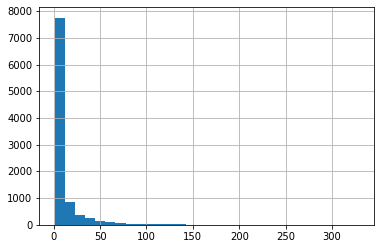

In [360]:
ratings_test = full[['title','rating']].groupby('title')['rating'].count()
ratings_test.hist(bins=30)
# xlabel('MoviedId')
# ylabel('Number of Ratings')

# **2. Exploratory data analysis + Data Preparation**

* Plot the counts of each rating
* Plot rating frequency of each movie

#### 1. Plot the counts of each rating

We first need to get the counts of each rating from ratings data

In [0]:
# # Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
# movies1 = movies
# movies1['year'] = movies1.title.str.extract("\((\d{4})\)", expand=True)
# movies1.year = pd.to_datetime(movies1.year, format='%Y')
# movies1.year = movies1.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
# # movies1.title = movies1.title.str[:-7]

In [362]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [0]:
# # Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
# genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
# genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
# movies1 = movies.join(movies.genres.str.get_dummies().astype(bool))
# movies1.drop('genres', inplace=True, axis=1)

In [364]:
movies.head()
ratings.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,30/07/2000 18:45:03
1,1,3,4.0,30/07/2000 18:20:47
2,1,6,4.0,30/07/2000 18:37:04
3,1,47,5.0,30/07/2000 19:03:35
4,1,50,5.0,30/07/2000 18:48:51


In [365]:
# movies1.head()
print("Movies dataset:\n Number of rows: {}\n Number of columns: {}"
.format(movies.shape[0],movies.shape[1]))
print("\nRatings dataset:\n Number of rows: {}\n Number of columns: {}"
.format(ratings.shape[0],ratings.shape[1]))

Movies dataset:
 Number of rows: 9742
 Number of columns: 3

Ratings dataset:
 Number of rows: 100836
 Number of columns: 4


In [366]:
## Create a dataframe to store the results(Count) for each group of ratings(1-5)
ratingCount = pd.DataFrame(ratings.groupby('rating').size(),columns=['Count'])
ratingCount

,Count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


We can see that above table does not include counts of zero rating score. So we need to add that in rating count dataframe as well

In [367]:
# The count for the rating of 0 is verey high 
total_cnt = num_users * num_movies
rating_zero_cnt = total_cnt - ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = ratingCount.append(
    pd.DataFrame({'Count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,Count
0.0,5830804
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


### **Feature Scaling**

The count for zero rating score is too big to compare with the other rating score. Therefore, a log transformation is needed to scale the values to a smaller number for model optimization of productivity and efficiency.

So let's take log transform for count values and then we can plot them to compare

In [368]:
# Add log count to the dataframe containing the number of ratings for each 
# rating category
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['Count'])
df_ratings_cnt

,Count,log_count
0.0,5830804,15.578665
0.5,1370,7.222566
1.0,2811,7.941296
1.5,1791,7.490529
2.0,7551,8.929435
2.5,5550,8.621553
3.0,20047,9.905835
3.5,13136,9.483112
4.0,26818,10.196829
4.5,8551,9.053804


Plotting a Bar Graph to visualize information in 'df_ratings_cnt' dataframe where it contains information on the (unique) count of ratings in the dataset.

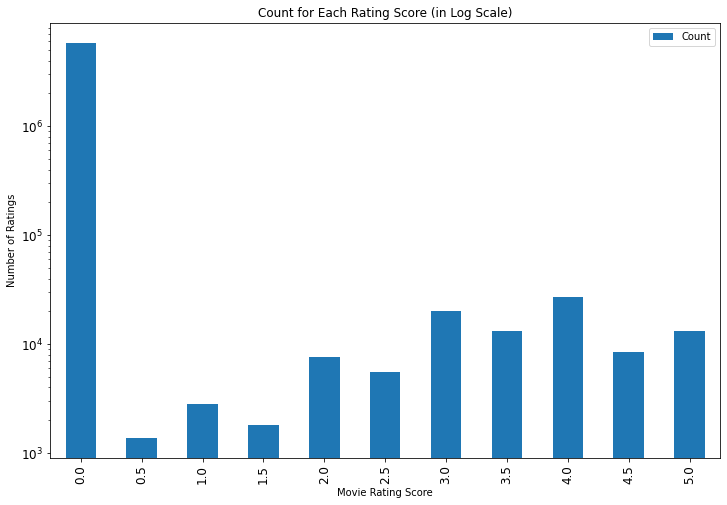

In [369]:
ax = df_ratings_cnt['Count'].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='Count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("Movie Rating Score")
ax.set_ylabel("Number of Ratings")
plt.show();

It is interesting to identify more reviews/ratings given a score of 3 and 4 compared to a rating of 5.

It's interesting that there are more people giving rating score of 3 and 4 than other scores

## **Plot rating frequencies for all movies**

Creating a dataframe for the ratings of each movie in the dataset.

In [370]:
df_movies_cnt = pd.DataFrame(ratings.groupby('movieId').size(),columns=['Count'])
df_movies_cnt.head()

,Count
movieId,
1,215
2,110
3,52
4,7
5,49


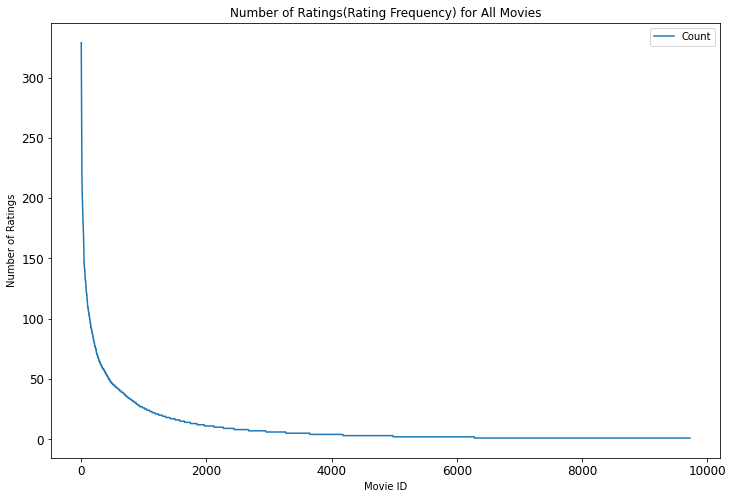

In [371]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('Count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Number of Ratings(Rating Frequency) for All Movies',
        fontsize=12
    )
ax.set_xlabel("Movie ID")
ax.set_ylabel("Number of Ratings")
plt.show();

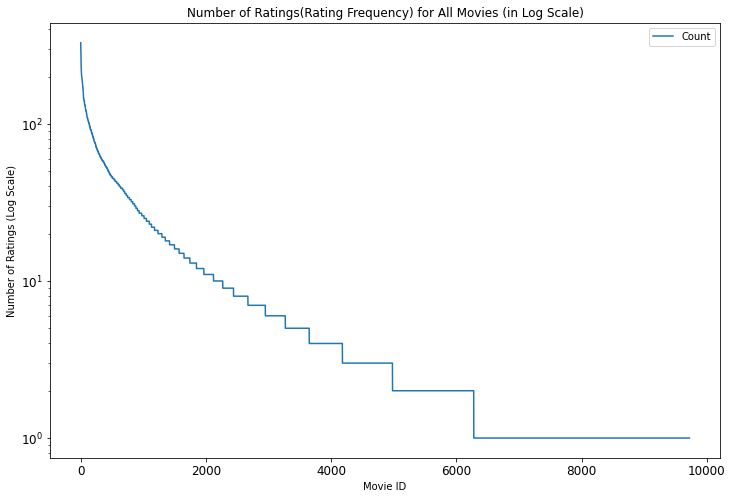

In [372]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('Count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Number of Ratings(Rating Frequency) for All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("Movie ID")
ax.set_ylabel("Number of Ratings (Log Scale)");

Return the 

The code snippet below retrieves the number of ratings(Count) in the given quantile for the specified list of values passed in the 'np.arrange' function. The output would return values from the 65th quantile to 100th quantile with a hop/skip of 5.

In [373]:
df_movies_cnt['Count'].quantile(np.arange(1, 0.6, -0.05))

1.00    329.0
0.95     47.0
0.90     27.0
0.85     17.0
0.80     12.0
0.75      9.0
0.70      7.0
0.65      5.0
Name: Count, dtype: float64

So about 1% of movies have roughly 329 or more ratings, 5% have 47 or more, and 20% have 12 or more. Since we have so many movies, we'll limit it to the top 25%. This is the arbitrary threshold for popularity, but it gives us about 13,500 different movies. We still have pretty good amount of movies for modeling. There are two reasons why we want to filter to roughly 13,500 movies in our dataset.

Memory issue: we don't want to run into the “MemoryError” during model training Improve KNN performance: lesser known movies have ratings from fewer viewers, making the pattern more noisy. Droping out less known movies can improve recommendation quality. However, with this concept in mind, this method will only be used for this algorithm as it might exclude recently added movies or movies that have a smaller user-base which might make the system a bit outdated if deployed as the movies it recommends would need to have a considerable amount of review before it can amke it way up as a recommended movie.

In [374]:
### Summing up the number of ratings for each movie ###
df_movies_cnt = pd.DataFrame(ratings.groupby('movieId').size(),columns=['Count'])
print(df_movies_cnt.head())

# filter data
popularity_thres = 50
### Keeping only movies with more than 50 reviews/ratings ###
popular_movies = list(set(df_movies_cnt.query('Count >= @popularity_thres').index))
df_ratings_drop_movies = ratings[ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

         Count
movieId       
1          215
2          110
3           52
4            7
5           49
shape of original ratings data:  (100836, 4)
shape of ratings data after dropping unpopular movies:  (41360, 4)


After dropping about 41% of movies in our dataset, we still have a relatively large dataset. So next we can filter users to further reduce the size of data

In [375]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['Count'])
print(df_users_cnt.head())
print(df_users_cnt.count())

# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('Count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('Shape of original Ratings data: ', ratings.shape)
print('Shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

        Count
userId       
1         117
2          15
3           6
4          84
5          34
Count    606
dtype: int64
Shape of original Ratings data:  (100836, 4)
Shape of ratings data after dropping both unpopular movies and inactive users:  (32999, 4)


### Rating Frequency of Users(Sum of ratings by User)

The code below plots a line graph of the total number of ratings given by every user in the dataset based on their user ID

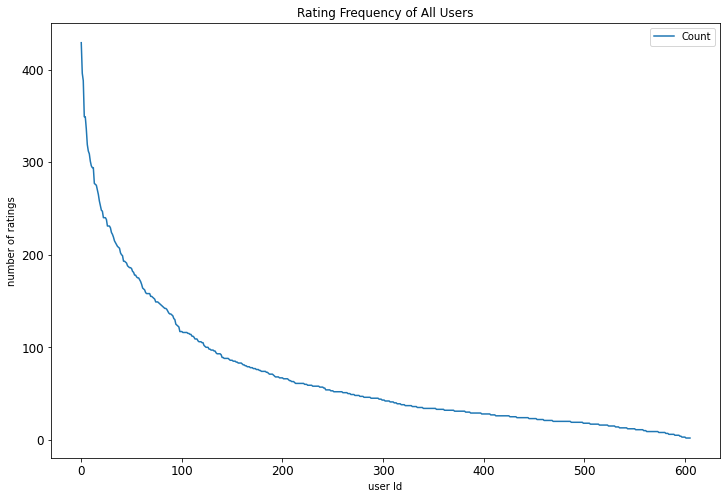

In [376]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('Count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings");

The code below overwrites the available variable 'full' with the new merge of both the movies and ammended ratings dataset to allow for faster processing of the datasets.

In [377]:
full = pd.merge(movies,df_ratings_drop_users,on='movieId')
# full.shape
print("Merge of two datasets(After Data Preparation):\n Number of rows: {} | Number of columns: {}".format(full.shape[0],full.shape[1]))

Merge of two datasets(After Data Preparation):
 Number of rows: 32999 | Number of columns: 6


## **Creating pivot table matrix**

Next, I will proceed to create a reshaped dataframe organized by User and Movie ID with the ratings as values. The output would resemble a pivot table except that not all of the values(cells) are being filled. The reason/purpose for performing this step is to prepare the data for use in the Singular Vector Decomposition(SVD) Collaborative Filtering algorithm to return a list of recommended movies based on _____.

In [378]:
Ratings = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
Ratings.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Last but not least, I need to de-normalize the data (normalize by each users mean) and convert it from a dataframe to a numpy array.

In [0]:
R = Ratings.values
user_ratings_mean = np.mean(R, axis = 1) # Numpy array containing the average rating for every user
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [380]:
Ratings_demeaned

array([[ 3.89582476, -0.10417524,  3.89582476, ..., -0.10417524,
        -0.10417524, -0.10417524],
       [-0.01177499, -0.01177499, -0.01177499, ..., -0.01177499,
        -0.01177499, -0.01177499],
       [-0.00976964, -0.00976964, -0.00976964, ..., -0.00976964,
        -0.00976964, -0.00976964],
       ...,
       [ 2.23215755,  1.73215755,  1.73215755, ..., -0.26784245,
        -0.26784245, -0.26784245],
       [ 2.98755656, -0.01244344, -0.01244344, ..., -0.01244344,
        -0.01244344, -0.01244344],
       [ 4.50611888, -0.49388112, -0.49388112, ..., -0.49388112,
        -0.49388112, -0.49388112]])

# **Data Modelling/Model Building**

# **Model-Based Collaborative Filtering**¶
Model-based Collaborative Filtering is based on matrix factorization (MF) which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF:

The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization, you can restructure the user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector. You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix. For example, let's check the sparsity of the ratings dataset:

In [381]:
sparsity = round(1.0 - len(ratings) / float(num_users * num_movies), 3)
print('The sparsity level of MovieLens1M dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens1M dataset is 98.3%


## **Setting Up SVD** Revisit later
Scipy and Numpy both have functions to do the singular value decomposition. I'm going to use the Scipy function svds because it let's me choose how many latent factors I want to use to approximate the original ratings matrix (instead of having to truncate it after).

In [0]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(Ratings_demeaned, k = 50)

As I'm going to leverage matrix multiplication to get predictions, I'll convert the  ΣΣ  (now are values) to the diagonal matrix form.

In [0]:
sigma = np.diag(sigma)

## **Making Predictions from the Decomposed Matrices** (Input UserID, output movies)
I now have everything I need to make movie ratings predictions for every user. I can do it all at once by following the math and matrix multiply  UU ,  ΣΣ , and  VTVT  back to get the rank  k=50k=50  approximation of  AA .

But first, I need to add the user means back to get the actual star ratings prediction.

In [0]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

With the predictions matrix for every user, I can build a function to recommend movies for any user. I return the list of movies the user has already rated, for the sake of comparison.

In [385]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
preds.head()

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.167328,0.402751,0.840184,-0.076281,-0.551337,2.504091,-0.890114,-0.026443,0.196974,1.593259,-0.474160,0.237581,0.346021,0.053504,-0.108999,1.355739,-0.426912,-0.077438,0.284485,0.417117,0.245054,0.362827,-0.139144,0.255003,0.067873,-0.220421,-0.033781,0.076522,-0.159481,-0.072023,-0.318595,0.774845,1.631756,-0.336022,0.139459,0.739682,-0.014906,0.084650,0.541279,0.134242,...,-0.178088,0.082812,0.039631,0.069620,0.039631,0.033760,0.016202,0.151717,0.036710,-0.172538,-0.155189,-0.121909,0.070459,0.038139,0.052525,0.090319,0.010978,0.012984,-0.018321,0.050599,-0.008879,-0.085795,-0.013370,0.006966,0.016995,0.004960,0.006966,0.004960,0.004960,-0.030425,-0.023453,-0.019967,-0.026939,-0.026939,-0.023453,-0.026939,-0.023453,-0.023453,-0.023453,-0.058732
1,0.211459,0.006658,0.033455,0.017419,0.183430,-0.062473,0.083037,0.024158,0.049330,-0.152530,0.077881,0.064805,0.005182,-0.001014,0.045648,0.096822,-0.027822,-0.004426,0.108646,-0.008286,-0.077978,0.016521,0.009482,0.023615,-0.212386,0.040676,-0.001671,-0.021906,-0.174248,0.013497,0.031743,-0.202221,-0.163632,0.030075,0.000392,-0.033238,0.000224,0.017713,0.009105,0.033852,...,0.107281,-0.026524,0.027091,0.011932,0.027091,0.016864,0.051425,0.069516,0.057564,-0.006654,-0.005944,0.014142,-0.002021,0.038409,0.035970,-0.002728,0.002845,0.003324,0.019168,-0.001314,-0.001049,-0.003101,0.009848,0.001888,0.004281,0.001410,0.001888,0.001410,0.001410,0.024940,0.019498,0.016777,0.022219,0.022219,0.019498,0.022219,0.019498,0.019498,0.019498,0.032281
2,0.003588,0.030518,0.046393,0.008176,-0.006247,0.107328,-0.012416,0.003779,0.007297,-0.059362,-0.005484,0.031175,0.019045,-0.008570,0.009015,0.029135,-0.021266,0.017135,-0.058321,-0.012562,-0.076699,0.011520,-0.014717,0.041779,-0.040655,-0.004429,-0.009282,-0.009510,0.071715,0.010940,0.023559,0.023674,-0.001701,0.006543,0.006831,0.067326,0.007865,-0.001794,0.011360,0.001821,...,0.010848,-0.005258,0.012808,0.017701,0.012808,0.012132,0.009292,0.002576,0.012102,-0.001268,-0.000341,0.020286,0.014689,0.004859,0.014408,0.016599,0.008085,0.008100,0.003702,0.012780,0.007564,0.003369,0.005910,0.008053,0.008131,0.008038,0.008053,0.008038,0.008038,0.005310,0.005909,0.006209,0.005610,0.005610,0.005909,0.005610,0.005909,0.005909,0.005909,0.008004
3,2.051549,-0.387104,-0.252199,0.087562,0.130465,0.270210,0.477835,0.040313,0.025858,-0.017365,0.637032,-0.092990,0.280611,0.268450,-0.027183,0.161275,1.801845,-0.258694,-0.035952,0.131731,1.912042,-0.169062,-0.034940,0.063111,1.661501,0.158679,0.026145,0.551609,0.492758,0.256954,-0.220697,2.094105,1.940568,0.880095,-0.077526,1.327586,0.003094,0.087768,0.102798,0.069933,...,-0.288689,0.111226,0.004181,0.059797,0.004181,0.006699,-0.011445,0.190691,-0.072316,0.121225,0.109122,-0.003448,-0.019439,0.049429,0.005512,-0.025047,-0.002677,-0.003250,0.010189,-0.013831,0.002714,0.060707,-0.022289,-0.001531,-0.004396,-0.000958,-0.001531,-0.000958,-0.000958,0.006164,0.004836,0.004172,0.005500,0.005500,0.004836,0.005500,0.004836,0.004836,0.004836,-0.023311
4,1.344738,0.778511,0.065749,0.111744,0.273144,0.584426,0.254930,0.128788,-0.085541,1.023455,0.974908,-0.070313,0.135688,0.237220,0.208138,0.552464,0.771266,-0.049298,0.326467,0.082279,1.158006,0.332666,0.156395,0.109681,0.861100,0.242800,0.033883,0.124262,0.044031,-0.000574,0.465793,1.254308,1.893785,0.999793,-0.017239,1.256341,-0.011412,0.111539,-0.012218,0.110956,...,-0.007826,0.023460,-0.006995,-0.012447,-0.006995,-0.004094,-0.009139,0.025778,0.004529,-0.017096,-0.015755,-0.002459,-0.006417,-0.003125,-0.008097,-0.007197,0.003527,0.004970,-0.009438,-0.005636,-0.003344,-0.010391,-

Now I write a function to return the movies with the highest predicted rating that the specified user hasn't already rated. Though I didn't use any explicit movie content features (such as genre or title), I'll merge in that information to get a more complete picture of the recommendations.

In [0]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

Let's try to recommend 20 movies for user with ID 10.

In [387]:
already_rated, predictions = recommend_movies(preds, 10, movies, ratings, 20)
# Top 20 movies that User 10 hopefully will enjoy
predictions

User 10 has already rated 140 movies.
Recommending highest 20 predicted ratings movies not already rated.


,movieId,title,genres
4394,6539,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy
7274,79132,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
5123,8368,Harry Potter and the Prisoner of Azkaban (2004),Adventure|Fantasy|IMAX
3553,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy
3547,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
3593,4963,Ocean's Eleven (2001),Crime|Thriller
4050,5816,Harry Potter and the Chamber of Secrets (2002),Adventure|Fantasy
7207,76093,How to Train Your Dragon (2010),Adventure|Animation|Children|Fantasy|IMAX
3601,4973,"Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le)...",Comedy|Romance
6003,40815,Harry Potter and the Goblet of Fire (2005),Adventure|Fantasy|Thriller|IMAX


In [388]:
# Top 20 movies that User 10 has rated 
already_rated.head(20)

,userId,movieId,rating,timestamp,title,genres
139,10,140110,5.0,13/02/2016 09:46:16,The Intern (2015),Comedy
48,10,8869,5.0,12/02/2016 18:51:04,First Daughter (2004),Comedy|Romance
117,10,96079,5.0,12/02/2016 18:36:12,Skyfall (2012),Action|Adventure|Thriller|IMAX
110,10,91529,5.0,12/02/2016 18:35:20,"Dark Knight Rises, The (2012)",Action|Adventure|Crime|IMAX
42,10,7458,5.0,13/02/2016 09:44:16,Troy (2004),Action|Adventure|Drama|War
100,10,81845,5.0,12/02/2016 18:43:11,"King's Speech, The (2010)",Drama
44,10,8533,5.0,12/02/2016 18:30:47,"Notebook, The (2004)",Drama|Romance
97,10,79091,5.0,12/02/2016 19:42:04,Despicable Me (2010),Animation|Children|Comedy|Crime
86,10,71579,5.0,12/02/2016 18:31:09,"Education, An (2009)",Drama|Romance
57,10,33794,5.0,12/02/2016 18:33:51,Batman Begins (2005),Action|Crime|IMAX


These look like pretty good recommendations. It's good to see that, although I didn't actually use the genre of the movie as a feature, the truncated matrix factorization features "picked up" on the underlying tastes and preferences of the user. I've recommended some comedy, drama, and romance movies - all of which were genres of some of this user's top rated movies.

## **Model Evaluation**
Can't forget to evaluate our model, can we?

Instead of doing manually like the last time, I will use the Surprise library that provided various ready-to-use powerful prediction algorithms including (SVD) to evaluate its RMSE (Root Mean Squared Error) on the MovieLens dataset. It is a Python scikit building and analyzing recommender systems.

In [389]:
# Import libraries from Surprise package
!pip install surprise
!pip install scikit-surprise
import surprise
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader

# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Use the SVD algorithm.
svd = SVD()

# Split the dataset for 5-fold evaluation
cross_validate(svd,data,measures=['RMSE'],cv=5)#verbose=True
# data.split(cv=5)

{'fit_time': (4.882619619369507,
  4.851840496063232,
  4.914399862289429,
  4.843437910079956,
  4.906903982162476),
 'test_rmse': array([0.88178173, 0.87192497, 0.86609864, 0.87266625, 0.87722113]),
 'test_time': (0.1416006088256836,
  0.13962101936340332,
  0.37824392318725586,
  0.16575956344604492,
  0.13855385780334473)}

I get a mean Root Mean Square Error of 0.8736 which is pretty good. Let's now train on the dataset and arrive at predictions.

In [390]:
trainset = data.build_full_trainset()
svd.fit(trainset)

I'll pick again user with ID 1310 and check the ratings he has given.

In [391]:
ratings[ratings['userId']==10]

,userId,movieId,rating,timestamp
1119,10,296,1.0,12/02/2016 18:56:27
1120,10,356,3.5,12/02/2016 18:28:05
1121,10,588,4.0,12/02/2016 19:42:53
1122,10,597,3.5,13/02/2016 10:00:45
1123,10,912,4.0,12/02/2016 18:37:34
...,...,...,...,...
1254,10,119145,1.0,12/02/2016 18:44:10
1255,10,129428,3.5,13/02/2016 09:56:24
1256,10,136020,5.0,12/02/2016 18:36:32
1257,10,137595,4.0,13/02/2016 09:48:18


Now let's use SVD to predict the rating that User with ID 1310 will give to a random movie (let's say with Movie ID 1994).

In [392]:
svd.predict(10,597)

Prediction(uid=10, iid=597, r_ui=None, est=3.650973473148014, details={'was_impossible': False})


For movie with ID 1994, I get an estimated prediction of 3.754. The recommender system works purely on the basis of an assigned movie ID and tries to predict ratings based on how the other users have predicted the movie.

## **Conclusion**
In this notebook, I attempted to build a **model-based Collaborative Filtering movie recommendation sytem** based on latent features from a low rank matrix factorization method called SVD. As it captures the underlying features driving the raw data, it can scale significantly better to massive datasets as well as make better recommendations based on user's tastes.

However, we still likely lose some meaningful signals by using a low-rank approximation. Specifically, there's an interpretability problem as a singular vector specifies a linear combination of all input columns or rows. There's also a lack of sparsity when the singular vectors are quite dense. Thus, SVD approach is limited to linear projections.

## **Feature Selection**

### **Multiple Model Training**

In [393]:
# from sklearn.model_selection import train_test_split
# from sklearn import ensemble
# from sklearn.metrics import mean_absolute_error
# from sklearn.externals import joblib
# # del features_df
# print(full.columns)
# # array = full.values
# features_df = pd.get_dummies(full,columns=['title','genres'])
# del features_df['rating']
# features_df.columns
# del features_df['timestamp']
# array = features_df.values
# # del features_df
# X = features_df.to_numpy()
# Y = full['rating'].to_numpy()

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_absolute_error
from sklearn.externals import joblib
# del features_df
print(full.columns)
features_df = pd.get_dummies(full,columns=['title','genres'])
features_df.columns
del features_df['timestamp']
del features_df['rating']

# del features_df
X = features_df.values
Y = full['rating'].values

Index(['movieId', 'title', 'genres', 'userId', 'rating', 'timestamp'], dtype='object')


Index(['movieId', 'userId', 'rating', 'timestamp',
       'title_10 Things I Hate About You (1999)', 'title_12 Angry Men (1957)',
       'title_2001: A Space Odyssey (1968)', 'title_28 Days Later (2002)',
       'title_300 (2007)', 'title_40-Year-Old Virgin, The (2005)',
       ...
       'genres_Fantasy|Sci-Fi', 'genres_Horror', 'genres_Horror|Mystery',
       'genres_Horror|Sci-Fi', 'genres_Horror|Sci-Fi|Thriller',
       'genres_Musical|Romance', 'genres_Mystery|Sci-Fi|Thriller',
       'genres_Mystery|Thriller', 'genres_Sci-Fi|IMAX', 'genres_Thriller'],
      dtype='object', length=658)

In [394]:
# # Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies1 = movies.join(movies.genres.str.get_dummies().astype(bool))
movies1.drop('genres', inplace=True, axis=1)
print(movies1.head())
print(movies1.columns)
full1 = pd.merge(movies1,df_ratings_drop_users,on='movieId')
features_df1 = pd.get_dummies(full1,columns=['Crime', 'Drama',
       'Mystery','Thriller', 'War'])
del features_df1['timestamp']
del features_df1['title'] # Remvoing this feature/column as the moviedId will be sufficient in identifying the movies
del features_df1['rating']
print(features_df1.head())
### Split the dataset into training(70%) and testing(30%) set ###
X_Train, X_Test, Y_Train, Y_Test=train_test_split(X1,Y1, test_size=0.3)

   movieId                               title  ...    War  Western
0        1                    Toy Story (1995)  ...  False    False
1        2                      Jumanji (1995)  ...  False    False
2        3             Grumpier Old Men (1995)  ...  False    False
3        4            Waiting to Exhale (1995)  ...  False    False
4        5  Father of the Bride Part II (1995)  ...  False    False

[5 rows x 22 columns]
Index(['movieId', 'title', '(no genres listed)', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')
   movieId  (no genres listed)  Action  ...  Thriller_True  War_False  War_True
0        1               False   False  ...              0          1         0
1        1               False   False  ...              0          1         0
2        1               False

In [395]:
features_df.columns
# print(X.size)
print(Y)
features_df.head()
# print(full.columns)

Index(['movieId', 'userId', 'title_10 Things I Hate About You (1999)',
       'title_12 Angry Men (1957)', 'title_2001: A Space Odyssey (1968)',
       'title_28 Days Later (2002)', 'title_300 (2007)',
       'title_40-Year-Old Virgin, The (2005)',
       'title_A.I. Artificial Intelligence (2001)', 'title_Abyss, The (1989)',
       ...
       'genres_Fantasy|Sci-Fi', 'genres_Horror', 'genres_Horror|Mystery',
       'genres_Horror|Sci-Fi', 'genres_Horror|Sci-Fi|Thriller',
       'genres_Musical|Romance', 'genres_Mystery|Sci-Fi|Thriller',
       'genres_Mystery|Thriller', 'genres_Sci-Fi|IMAX', 'genres_Thriller'],
      dtype='object', length=656)

[4.  4.5 2.5 ... 4.  3.5 3. ]


,movieId,userId,title_10 Things I Hate About You (1999),title_12 Angry Men (1957),title_2001: A Space Odyssey (1968),title_28 Days Later (2002),title_300 (2007),"title_40-Year-Old Virgin, The (2005)",title_A.I. Artificial Intelligence (2001),"title_Abyss, The (1989)",title_Ace Ventura: Pet Detective (1994),title_Ace Ventura: When Nature Calls (1995),title_Addams Family Values (1993),title_Air Force One (1997),title_Airplane! (1980),title_Aladdin (1992),title_Alien (1979),title_Aliens (1986),title_Almost Famous (2000),title_Amadeus (1984),"title_Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)",title_American Beauty (1999),title_American History X (1998),title_American Pie (1999),"title_American President, The (1995)",title_American Psycho (2000),title_Anchorman: The Legend of Ron Burgundy (2004),title_Animal House (1978),title_Annie Hall (1977),title_Apocalypse Now (1979),title_Apollo 13 (1995),title_Arachnophobia (1990),title_Armageddon (1998),title_Army of Darkness (1993),title_As Good as It Gets (1997),title_Austin Powers in Goldmember (2002),title_Austin Powers: International Man of Mystery (1997),title_Austin Powers: The Spy Who Shagged Me (1999),title_Avatar (2009),"title_Avengers, The (2012)",...,genres_Crime|Drama|Sci-Fi|Thriller,genres_Crime|Drama|Thriller,genres_Crime|Film-Noir|Mystery|Thriller,genres_Crime|Horror,genres_Crime|Horror|Mystery|Thriller,genres_Crime|Horror|Thriller,genres_Crime|Mystery|Thriller,genres_Crime|Thriller,genres_Documentary,genres_Drama,genres_Drama|Fantasy|Romance,genres_Drama|Fantasy|Thriller,genres_Drama|Horror,genres_Drama|Horror|Mystery,genres_Drama|Horror|Mystery|Thriller,genres_Drama|Horror|Thriller,genres_Drama|Musical|Romance,genres_Drama|Mystery,genres_Drama|Mystery|Romance|Thriller,genres_Drama|Mystery|Sci-Fi|Thriller,genres_Drama|Mystery|Thriller,genres_Drama|Romance,genres_Drama|Romance|Sci-Fi,genres_Drama|Romance|War|Western,genres_Drama|Sci-Fi,genres_Drama|Sci-Fi|Thriller,genres_Drama|Thriller,genres_Drama|Thriller|War,genres_Drama|War,genres_Fantasy|Horror|Mystery|Romance,genres_Fantasy|Sci-Fi,genres_Horror,genres_Horror|Mystery,genres_Horror|Sci-Fi,genres_Horror|Sci-Fi|Thriller,genres_Musical|Romance,genres_Mystery|Sci-Fi|Thriller,genres_Mystery|Thriller,genres_Sci-Fi|IMAX,genres_Thriller
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
### Split the dataset into training(70%) and testing(30%) set ###
X_Train, X_Test, Y_Train, Y_Test=train_test_split(X,Y, test_size=0.3)

In [0]:
# Determine the accuracy of the model, to find out how accurate the model can predict the values of the Iris dataset based on the training data fed
# Test options and evaluation metric
seed = 7
scoring = "accuracy"

In [0]:
# from sklearn import model_selection
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB

# # Spot Check Algorithms
# models = []
# # models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=200)))
# # models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN', KNeighborsClassifier()))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# # models.append(('SVM',SVC(gamma='auto')))


# # evaluate each model in turn
# results = []
# names = []
# for name, model in models:    
#     kfold = model_selection.KFold(n_splits=10, random_state=seed)    
#     cv_results = model_selection.cross_val_score(model, X_Train, Y_Train, cv=kfold, scoring=scoring)       
#     results.append(cv_results)    
#     names.append(name)    
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())    
#     print(msg)

#### Gradient Boosting Regressor

The second model that I will be using for this project is the Gradient Boosting Regressor which is a type of inductively generated tree ensemble model where the previous negative gradient of the loss function is used as the input for the next Decision Tree.

In [399]:
## Fitting the regression model ##
model = ensemble.GradientBoostingRegressor(
    n_estimators=1000, # Number of decision trees to build
    learning_rate=0.1, # How much decision trees influence overall prediction
    max_depth=6,
    min_samples_leaf=9,
    max_features=0.1,
    loss='huber',
    random_state=7)
model.fit(X_Train,Y_Train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=6, max_features=0.1, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=9, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=7, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [400]:
joblib.dump(model,'models//GradientBoostRegressor.pkl')

['models//GradientBoostRegressor.pkl']

##### **Measuring Accuracy**

In [0]:
### Not using IsolationForest
# ## Fitting the regression model ##
# model = ensemble.IsolationForest(
#     n_estimators=100) # Number of decision trees to build)
# model.fit(X_Train,Y_Train)
# x_pred = model.predict(X_Train)

# ### Check the accuracy using actual and predicted values.
# #Import scikit-learn metrics module for accuracy calculation
# from sklearn import metrics
# # Model Accuracy, how often is the classifier correct?
# print("Accuracy:",metrics.accuracy_score(X_Test, x_pred))

In [402]:
#Find the error rate on the training set
mae = mean_absolute_error(Y_Train, model.predict(X_Train))
mse = mean_squared_error(Y_Train, model.predict(X_Train))
print("Training set Analysis:\n Gradient Boosting Regressor Training set Mean Absolute Error: %.4f" % mae)
print("Training Set Mean Square Error: %.4f" % mse)

#Find the error rate on the training set
mae1=mean_absolute_error(Y_Test, model.predict(X_Test))
mse1 = mean_squared_error(Y_Test, model.predict(X_Test))
print("\nGradient Boosting Regressor Testing set Mean Absolute Error: %.4f" % mae1)
print("Testing Set Mean Square Error: %.4f" % mse1)

Training set Analysis:
 Gradient Boosting Regressor Training set Mean Absolute Error: 0.6044
Training Set Mean Square Error: 0.6465

Gradient Boosting Regressor Testing set Mean Absolute Error: 0.6886
Testing Set Mean Square Error: 0.8164


#### **Bagging Regressor**

The cod below utilizes the Bagging Regressor to train a model for prediction and return the Mean Absolute Error(MAE) of both the training and testing dataset. The advantage and reason for using the Bagging Regressor is that it reduces variance when training the model which in turns avoid overfitting of the model. However, it should be used with caution/ as the process can be computationally expensive depending on the use case and size of the dataset.

In [403]:
# lr = LogisticRegression()
# clf = OneVsRestClassifier(lr)
# clf.fit(X_Train,Y_Train)
model2 = ensemble.BaggingRegressor(n_estimators=1000,max_samples=9,
                                  max_features=0.1,random_state=7)
model2.fit(X_Train,Y_Train)
y_pred = model2.predict(X_Test)

BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False,
                 max_features=0.1, max_samples=9, n_estimators=1000,
                 n_jobs=None, oob_score=False, random_state=7, verbose=0,
                 warm_start=False)

##### **Measuring Accuracy**

In [404]:
#Find the error rate on the training set
mae2=mean_absolute_error(Y_Train, model2.predict(X_Train))
mse2 = mean_squared_error(Y_Train, model2.predict(X_Train))
print("Training set Analysis:\n Bagging Regressor Training set Mean Absolute Error: %.4f" % mae2)
print("Training Set Mean Square Error: %.4f" % mse2)

#Find the error rate on the training set
mae3 = mean_absolute_error(Y_Test, model2.predict(X_Test))# *
mse3 = mean_squared_error(Y_Test, model2.predict(X_Test))
print("\nBagging Regressor Testing set Mean Absolute Error: %.4f" % mae2)
print("Testing Set Mean Square Error: %.4f" % mse2)

Training set Analysis:
 Bagging Regressor Training set Mean Absolute Error: 0.7752
Training Set Mean Square Error: 0.9484

Bagging Regressor Testing set Mean Absolute Error: 0.7752
Testing Set Mean Square Error: 0.9484


In [405]:
# How do you calculate error rate in classification?
model2.fit(X_Train, Y_Train).score(X_Train, Y_Train)

0.004973380952153494

In [0]:
# print(classification_report(Y_Train, y_pred, target_names=Y_Test))

#### **Random Forest Regressor**

In [407]:
## Fitting the regression model ##
model1 = ensemble.RandomForestRegressor(
    n_estimators=1000, # Number of decision trees to build
    criterion='mse',
    min_samples_leaf=9,
    max_depth=6,
    max_features=0.1,
  random_state=7)
model1.fit(X_Train,Y_Train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features=0.1, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=9,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)

##### Measuring Accuracy

In [408]:
#Find the error rate on the training set
mae4=mean_absolute_error(Y_Train, model1.predict(X_Train))
mse4 = mean_squared_error(Y_Train, model1.predict(X_Train))
print("Training set Analysis:\n Bagging Regressor Training set Mean Absolute Error: %.4f" % mae4)
print("Training Set Mean Square Error: %.4f" % mse4)

#Find the error rate on the testing set
mae5=mean_absolute_error(Y_Test, model1.predict(X_Test))# *
mse5 = mean_squared_error(Y_Test, model1.predict(X_Test))
print("\nTesting set Analysis:\nBagging Regressor Testing set Mean Squared Error: %.4f" % mae5)
print("Testing Set Mean Square Error: %.4f" % mse5)

print("\nFinal Training Analysis:\n GBR Training MAE: %.4f" % mae,"| GBR Training MSE: %.4f" % mse,
      "\nBagging Training MAE: %.4f" % mae2,"| Bagging Training MSE: %.4f" % mse2,
      "\nRandom Forest Training MAE: %.4f" % mae4,"| Random Forest Training MSE: %.4f" % mse4)

print("\nFinal Testing Analysis:\n GBR Testing MAE: %.4f" % mae1,"| GBR Testing MSE: %.4f" % mse1,
      "\nBagging Testing MAE: %.4f" % mae2,"| Bagging Testing MSE: %.4f" % mse2,
      "\nRandom Forest Testing MAE: %.4f" % mae5,"| Random Forest Testing MSE: %.4f" % mse5)

Training set Analysis:
 Bagging Regressor Training set Mean Absolute Error: 0.7585
Training Set Mean Square Error: 0.9154

Testing set Analysis:
Bagging Regressor Testing set Mean Squared Error: 0.7639
Testing Set Mean Square Error: 0.9364

Final Training Analysis:
 GBR Training MAE: 0.6044 | GBR Training MSE: 0.6465 
Bagging Training MAE: 0.7752 | Bagging Training MSE: 0.9484 
Random Forest Training MAE: 0.7585 | Random Forest Training MSE: 0.9154

Final Testing Analysis:
 GBR Testing MAE: 0.6886 | GBR Testing MSE: 0.8164 
Bagging Testing MAE: 0.7752 | Bagging Testing MSE: 0.9484 
Random Forest Testing MAE: 0.7639 | Random Forest Testing MSE: 0.9364


# **Random Search(Replace Grid Search)**
For this section, I am using Random Search instead of Grid Search as Random search is better than grid search as it is able to take into account more unique values of each hyperparameter. This is important because some hyperparamters are more important than others.

In [410]:
# Parameters we want to try
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [4, 6],
    'min_samples_leaf': [3, 5, 9, 17],
    'learning_rate': [0.1, 0.05, 0.02, 0.01],
    'max_features': [1.0, 0.3, 0.1],
    'loss': ['ls', 'lad', 'huber']
}

from sklearn.model_selection import RandomizedSearchCV
randomizedsearch = RandomizedSearchCV(model, param_grid,verbose=20)
best_model_random = randomizedsearch.fit(X_Train, Y_Train)
print(best_model_random.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=100, min_samples_leaf=9, max_features=1.0, max_depth=6, loss=lad, learning_rate=0.1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KeyboardInterrupt: ignored

### Measuring Accuracy (Random Search)

In [412]:
# Find the error rate on the training set using the best parameters
mae = mean_absolute_error(Y_Train, best_model_random.predict(X_Train))
mse = mean_squared_error(Y_Train, best_model_random.predict(X_Train))
print("Random Search Analysis \n Training Set Mean Absolute Error: %.4f" % mae)
print("Training Set Mean Square Error: %.4f" % mse)
# Find the error rate on the test set using the best parameters
mae = mean_absolute_error(Y_Test, best_model_random.predict(X_Test))
mse = mean_squared_error(Y_Test, best_model_random.predict(X_Test))
print("\nTest Set Mean Absolute Error: %.4f" % mae)
print("Test Set Mean Square Error: %.4f" % mse)

Random Search Analysis 
 Training Set Mean Absolute Error: 0.6628
Training Set Mean Square Error: 0.7591

Test Set Mean Absolute Error: 0.6710
Test Set Mean Square Error: 0.7755


## Feature Importance
Display percentage

Splitting Genres

In [413]:
# # Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies1 = movies.join(movies.genres.str.get_dummies().astype(bool))
movies1.drop('genres', inplace=True, axis=1)
print(movies1.head())
print(movies1.columns)
full1 = pd.merge(movies1,df_ratings_drop_users,on='movieId')
features_df1 = pd.get_dummies(full1,columns=['Crime', 'Drama',
       'Mystery','Thriller', 'War'])
del features_df1['timestamp']
del features_df1['title'] # Remvoing this feature/column as the moviedId will be sufficient in identifying the movies
del features_df1['rating']

X1 = features_df1.values
Y1 = full1['rating'].values
### Split the dataset into training(70%) and testing(30%) set ###
X_Train, X_Test, Y_Train, Y_Test=train_test_split(X1,Y1, test_size=0.3)

   movieId                               title  ...    War  Western
0        1                    Toy Story (1995)  ...  False    False
1        2                      Jumanji (1995)  ...  False    False
2        3             Grumpier Old Men (1995)  ...  False    False
3        4            Waiting to Exhale (1995)  ...  False    False
4        5  Father of the Bride Part II (1995)  ...  False    False

[5 rows x 22 columns]
Index(['movieId', 'title', '(no genres listed)', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')


In [414]:
x = features_df1.columns
# using list comprehension to  
# elements from list  
x1 = list(x)
      
# printing result 
print ("Resultant list : " + str(x1)) 

# Feature Labels
feature_labels = np.array(['movieId', '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Documentary', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Romance', 'Sci-Fi', 'Western', 'userId', 'Crime_False', 'Crime_True', 'Drama_False', 'Drama_True', 'Mystery_False', 'Mystery_True', 'Thriller_False', 'Thriller_True', 'War_False', 'War_True'])

Resultant list : ['movieId', '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Documentary', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Romance', 'Sci-Fi', 'Western', 'userId', 'Crime_False', 'Crime_True', 'Drama_False', 'Drama_True', 'Mystery_False', 'Mystery_True', 'Thriller_False', 'Thriller_True', 'War_False', 'War_True']


In [415]:
from sklearn.externals import joblib

# Load the model we trained previously
model = joblib.load('models//GradientBoostRegressor.pkl')

#Create a numpy array based on the model's feature imprtances
importance = model.feature_importances_

#Sort the feature labels based on the feature imortance rankings from the model
feature_indexes_by_importance=importance.argsort()

# Print each feature label, from most importance to least important(reverse order)
for index in feature_indexes_by_importance:
   print("{} - {:.2f}".format(feature_labels[index], (importance[index]*100.0)))

IndexError: ignored

## **Prediction for 1 row of data** - Success

In [0]:
## Fitting the regression model ##
model = ensemble.GradientBoostingRegressor(
    n_estimators=1000, # Number of decision trees to build
    learning_rate=0.1, # How much decision trees influence overall prediction
    max_depth=6,
    min_samples_leaf=9,
    max_features=0.1,
    loss='huber',
    random_state=7)
model.fit(X_Train,Y_Train)
joblib.dump(model,'models//GradientBoostRegressor.pkl')

In [0]:
from sklearn.externals import joblib
# Load the model we trained previously
model = joblib.load('models//GradientBoostRegressor.pkl')
# For the house we want to value, we need to provide the features in the exact same
# arrangement as our training data set.
movie_rating = [
    # Movie features
    524, # movieId - 22.49
    
    # User ID - Enter 1 ID
    199,     # userId - 48.26
    
    
    # Genre - Min 1, Max 4
    0,       # (no genres listed) - 0.00
    0,        # Documentary - 0.04
    0,        # Film-Noir - 0.08
    0,       # Musical - 0.35
    0,        # Western - 0.39
    0,        # Mystery_True - 0.54
    0,        # IMAX - 0.58
    0,        # War_False - 0.69
    0,        # War_True - 0.69
    0,        # Children - 0.80
    0,        # Animation - 0.86
    0,        # Horror - 0.89
    0,        # Mystery_False - 0.96
    0,        # Romance - 1.16
    0,        # Thriller_False - 1.22
    0,        # Thriller_True - 1.25
    0,        # Fantasy - 1.39
    0,        # Adventure - 1.48
    0,        # Crime_True - 1.52
    0,        # Crime_False - 1.60
    0,        # Drama_False - 1.60
    0,        # Drama_True - 1.71
    1,        # Sci-Fi - 1.82
    0,        # Comedy - 3.49
    1        # Action - 4.15
]


The rating will change for every amendment made to the variables above and it will vary based on the feature importance statistics returned above. However, the User ID and Movie ID has to be available in the dataset.

In [0]:
# scikit-learn assumes you want to predict the values for lots of houses at once, so it expects an array.
# We just want to look at a single house, so it will be the only item in our array.
movie_rating1 = [movie_rating]
# Run the model and make a prediction for each house in the homes_to_value array
predicted_movie_values = model.predict(movie_rating1)
# Since we are only predicting the price of one house, just look at the first prediction returned
predicted_value = predicted_movie_values[0]
print("This movie has an estimated rating of {:,.2f}".format(predicted_value))

### Splitting genres

In [0]:
movies1.head()

### Can only be used with Jupter Notebook ###
# import webbrowser
# import os

# html=movies1[0:100].to_html()

# with open("data.html","w") as f:
#          f.write(html)
          
# full_filename=os.path.abspath("data.html")
# webbrowser.open("file://{}".format(full_filename))

In [0]:
# # Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies1 = movies.join(movies.genres.str.get_dummies().astype(bool))
movies1.drop('genres', inplace=True, axis=1)
print(movies1.head())
print(movies1.columns)
full1 = pd.merge(movies1,df_ratings_drop_users,on='movieId')
features_df1 = pd.get_dummies(full1,columns=['Crime', 'Drama',
       'Mystery','Thriller', 'War'])
del features_df1['timestamp']
del features_df1['title'] # Remvoing this feature/column as the moviedId will be sufficient in identifying the movies
del features_df1['rating']
print(features_df1.head())

In [0]:
# feature_labels1 = np.array(['movieId', 'title', '(no genres listed)', 'Action', 'Adventure',
      #  'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
      #  'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
      #  'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
# features_df = pd.get_dummies(full1,columns=['title','genres'])
# features_df1 = features_df
X1 = features_df1.values
Y1 = full1['rating'].values

#### Higher level One-Hot Encoding

In [0]:
features_df2 = pd.get_dummies(full1,columns=['(no genres listed)', 'Action', 'Adventure',
       'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'])
del features_df2['timestamp']
del features_df2['title'] # Removing this feature/column as the moviedId will be sufficient in identifying the movies
del features_df2['rating']
features_df2.head()

In [0]:
#### Including more features for One-Hot Encoding ####
### One-Hot Encoding for all variables
X2 = features_df2.values
Y2 = full1['rating'].values

### Split the dataset into training(70%) and testing(30%) set ###
X_Train, X_Test, Y_Train, Y_Test=train_test_split(X2,Y2, test_size=0.3)

################# End of 'Higher Level One-Hot Encoding' Section ##############################

In [0]:
### Split the dataset into training(70%) and testing(30%) set ###
X_Train, X_Test, Y_Train, Y_Test=train_test_split(X1,Y1, test_size=0.3)

In [0]:
## Fitting the regression model ##
model = ensemble.GradientBoostingRegressor(
    n_estimators=1000, # Number of decision trees to build
    learning_rate=0.1, # How much decision trees influence overall prediction
    max_depth=6,
    min_samples_leaf=9,
    max_features=0.1,
    loss='huber',
    random_state=7)
model.fit(X_Train,Y_Train)

In [0]:
joblib.dump(model,'models//GradientBoostRegressor.pkl')

In [0]:
# Find the error rate on the testing set
mse = mean_squared_error(Y_Train,model.predict(X_Train))
print("Training set Mean Squared Error: %.4f" % mse)

# Find the error rate on the testing set
mse = mean_squared_error(Y_Test,model.predict(X_Test))
print("Testing set Mean Squared Error: %.4f" % mse)

In [0]:
importance.size

In [0]:
# These are the feature labels from our data set
feature_labels = np.array(['movieId', 'userId', 'title_10 Things I Hate About You (1999)', 'title_12 Angry Men (1957)', 
                           'title_2001: A Space Odyssey (1968)', 'title_28 Days Later (2002)', 'title_300 (2007)', 
                           'title_40-Year-Old Virgin, The (2005)', 'title_A.I. Artificial Intelligence (2001)', 
                           'title_Abyss, The (1989)', 'title_Ace Ventura: Pet Detective (1994)', 
                           'title_Ace Ventura: When Nature Calls (1995)', 'title_Addams Family Values (1993)', 
                           'title_Air Force One (1997)', 'title_Airplane! (1980)', 'title_Aladdin (1992)', 
                           'title_Alien (1979)', 'title_Aliens (1986)', 'title_Almost Famous (2000)', 'title_Amadeus (1984)',
                           "title_Amelie (Fabuleux destin d'AmÃ©lie Poulain, Le) (2001)", 
                           'title_American Beauty (1999)', 'title_American History X (1998)', 
                           'title_American Pie (1999)', 'title_American President, The (1995)', 
                           'title_American Psycho (2000)', 'title_Anchorman: The Legend of Ron Burgundy (2004)', 
                           'title_Animal House (1978)', 'title_Annie Hall (1977)', 'title_Apocalypse Now (1979)', 
                           'title_Apollo 13 (1995)', 'title_Arachnophobia (1990)', 'title_Armageddon (1998)', 'title_Army of Darkness (1993)', 
                           'title_As Good as It Gets (1997)', 'title_Austin Powers in Goldmember (2002)', 
                           'title_Austin Powers: International Man of Mystery (1997)', 'title_Austin Powers: The Spy Who Shagged Me (1999)', 
                           'title_Avatar (2009)', 'title_Avengers, The (2012)', 'title_Babe (1995)', 'title_Back to the Future (1985)', 
                           'title_Back to the Future Part II (1989)', 'title_Back to the Future Part III (1990)', 'title_Bad Boys (1995)',
                           'title_Batman (1989)', 'title_Batman Begins (2005)', 'title_Batman Forever (1995)', 'title_Batman Returns (1992)',
                           'title_Beautiful Mind, A (2001)', 'title_Beauty and the Beast (1991)', 'title_Beetlejuice (1988)', 
                           'title_Being John Malkovich (1999)', 'title_Best in Show (2000)', 'title_Beverly Hills Cop III (1994)', 
                           'title_Big (1988)', 'title_Big Fish (2003)', 'title_Big Lebowski, The (1998)', 'title_Birdcage, The (1996)',
                           'title_Black Hawk Down (2001)', 'title_Blade (1998)', 'title_Blade Runner (1982)', 'title_Blair Witch Project, The (1999)',
                           'title_Blazing Saddles (1974)', 'title_Blood Diamond (2006)', 'title_Blow (2001)', 'title_Blues Brothers, The (1980)', 
                           'title_Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan (2006)', 
                           'title_Bourne Identity, The (2002)', 'title_Bourne Supremacy, The (2004)', 'title_Bourne Ultimatum, The (2007)',
                           'title_Bowling for Columbine (2002)', 'title_Braveheart (1995)', 'title_Brazil (1985)', 
                           'title_Breakfast Club, The (1985)', "title_Bridget Jones's Diary (2001)", 'title_Broken Arrow (1996)',
                           'title_Bruce Almighty (2003)', "title_Bug's Life, A (1998)", 'title_Butch Cassidy and the Sundance Kid (1969)', 
                           'title_Cable Guy, The (1996)', 'title_Caddyshack (1980)', 'title_Casablanca (1942)', 'title_Casino (1995)',
                           'title_Casino Royale (2006)', 'title_Casper (1995)', 'title_Cast Away (2000)', 'title_Catch Me If You Can (2002)', 
                           'title_Charlie and the Chocolate Factory (2005)', "title_Charlie's Angels (2000)", 'title_Chasing Amy (1997)', 
                           'title_Chicken Run (2000)', 'title_Children of Men (2006)', 'title_Chinatown (1974)', 'title_Christmas Story, A (1983)',
                           'title_Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)', 'title_Citizen Kane (1941)',
                           "title_City Slickers II: The Legend of Curly's Gold (1994)", 'title_City of God (Cidade de Deus) (2002)', 
                           'title_Clear and Present Danger (1994)', 'title_Clerks (1994)', 'title_Client, The (1994)', 'title_Cliffhanger (1993)', 
                           'title_Clockwork Orange, A (1971)', 'title_Close Encounters of the Third Kind (1977)', 'title_Clueless (1995)', 
                           'title_Con Air (1997)', 'title_Coneheads (1993)', 'title_Congo (1995)', 'title_Contact (1997)', 
                           'title_Cool Hand Luke (1967)', 'title_Crash (2004)', 'title_Crimson Tide (1995)', 
                           'title_Crocodile Dundee (1986)', 'title_Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)', 
                           'title_Crow, The (1994)', 'title_Dances with Wolves (1990)', 'title_Dark Knight Rises, The (2012)', 
                           'title_Dark Knight, The (2008)', 'title_Dave (1993)', 'title_Day After Tomorrow, The (2004)', 
                           'title_Dead Man Walking (1995)', 'title_Dead Poets Society (1989)', 'title_Deadpool (2016)', 
                           'title_Demolition Man (1993)', 'title_Departed, The (2006)', 'title_Desperado (1995)', 
                           'title_Die Hard (1988)', 'title_Die Hard 2 (1990)', 'title_Die Hard: With a Vengeance (1995)',
                           'title_Disclosure (1994)', 'title_District 9 (2009)', 'title_Django Unchained (2012)', 
                           'title_Dogma (1999)', 'title_Donnie Brasco (1997)', 'title_Donnie Darko (2001)', 
                           'title_Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 'title_Dragonheart (1996)', 
                           'title_Dumb & Dumber (Dumb and Dumber) (1994)', 'title_E.T. the Extra-Terrestrial (1982)', 'title_Ed Wood (1994)',
                           'title_Edward Scissorhands (1990)', 'title_Election (1999)', 'title_Enemy of the State (1998)', 'title_Eraser (1996)',
                           'title_Erin Brockovich (2000)', 'title_Eternal Sunshine of the Spotless Mind (2004)', 'title_Exorcist, The (1973)',
                           'title_Eyes Wide Shut (1999)', 'title_Face/Off (1997)', 'title_Fantasia (1940)', 'title_Fargo (1996)',
                           "title_Ferris Bueller's Day Off (1986)", 'title_Few Good Men, A (1992)', 'title_Field of Dreams (1989)', 
                           'title_Fifth Element, The (1997)', 'title_Fight Club (1999)', 'title_Finding Nemo (2003)', 'title_Firm, The (1993)',
                           'title_First Knight (1995)', 'title_Fish Called Wanda, A (1988)', 'title_Forrest Gump (1994)', 
                           'title_Four Weddings and a Funeral (1994)', 'title_From Dusk Till Dawn (1996)', 'title_Fugitive, The (1993)',
                           'title_Full Metal Jacket (1987)', 'title_Full Monty, The (1997)', 'title_Galaxy Quest (1999)', 'title_Game, The (1997)',
                           'title_Gangs of New York (2002)', 'title_Gattaca (1997)', 'title_Get Shorty (1995)', 'title_Ghost (1990)',
                           'title_Ghostbusters (a.k.a. Ghost Busters) (1984)', 'title_Gladiator (2000)', 'title_Godfather, The (1972)',
                           'title_Godfather: Part II, The (1974)', 'title_GoldenEye (1995)', 'title_Goldfinger (1964)', 
                           'title_Gone in 60 Seconds (2000)', 'title_Good Will Hunting (1997)', 
                           'title_Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)', 
                           'title_Goodfellas (1990)', 'title_Goonies, The (1985)', 'title_Graduate, The (1967)',
                           'title_Grand Budapest Hotel, The (2014)', 'title_Grease (1978)', 'title_Green Mile, The (1999)',
                           'title_Grosse Pointe Blank (1997)', 'title_Groundhog Day (1993)', 'title_Grumpier Old Men (1995)', 
                           'title_Guardians of the Galaxy (2014)', 'title_Hangover, The (2009)', 'title_Happy Gilmore (1996)',
                           'title_Harry Potter and the Chamber of Secrets (2002)', 'title_Harry Potter and the Deathly Hallows: Part 2 (2011)', 
                           'title_Harry Potter and the Goblet of Fire (2005)', 'title_Harry Potter and the Half-Blood Prince (2009)', 
                           'title_Harry Potter and the Order of the Phoenix (2007)', 'title_Harry Potter and the Prisoner of Azkaban (2004)', 
                           "title_Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)", 'title_Heat (1995)', 
                           'title_High Fidelity (2000)', 'title_Home Alone (1990)', 'title_Honey, I Shrunk the Kids (1989)', 'title_Hook (1991)', 
                           'title_Hot Fuzz (2007)', 'title_Hot Shots! Part Deux (1993)', 'title_How to Train Your Dragon (2010)', 'title_Hunt for Red October, The (1990)', 'title_I Am Legend (2007)', 'title_I, Robot (2004)', 'title_Ice Age (2002)', 'title_In the Line of Fire (1993)', 'title_Inception (2010)', 'title_Incredibles, The (2004)', 'title_Independence Day (a.k.a. ID4) (1996)', 'title_Indiana Jones and the Last Crusade (1989)', 'title_Indiana Jones and the Temple of Doom (1984)', 'title_Inglourious Basterds (2009)', 'title_Interstellar (2014)', 'title_Interview with the Vampire: The Vampire Chronicles (1994)', 'title_Iron Man (2008)', "title_It's a Wonderful Life (1946)", 'title_Italian Job, The (2003)', 'title_Jaws (1975)', 'title_Jerry Maguire (1996)', 'title_Johnny Mnemonic (1995)', 'title_Judge Dredd (1995)', 'title_Jumanji (1995)', 'title_Jungle Book, The (1967)', 'title_Juno (2007)', 'title_Jurassic Park (1993)', 'title_Kill Bill: Vol. 1 (2003)', 'title_Kill Bill: Vol. 2 (2004)', "title_King's Speech, The (2010)", 'title_Knocked Up (2007)', 'title_Kung Fu Panda (2008)', 'title_L.A. Confidential (1997)', 'title_Lady and the Tramp (1955)', 'title_Last Action Hero (1993)', 'title_Last Samurai, The (2003)', 'title_Leaving Las Vegas (1995)', 'title_Legally Blonde (2001)', 'title_Legends of the Fall (1994)', 'title_Lethal Weapon (1987)', 'title_Liar Liar (1997)', 'title_Life Is Beautiful (La Vita Ã¨ bella) (1997)', 'title_Lion King, The (1994)', 'title_Little Mermaid, The (1989)', 'title_Little Miss Sunshine (2006)', 'title_Lock, Stock & Two Smoking Barrels (1998)', 'title_Lord of the Rings: The Fellowship of the Ring, The (2001)', 'title_Lord of the Rings: The Return of the King, The (2003)', 'title_Lord of the Rings: The Two Towers, The (2002)', 'title_Lost World: Jurassic Park, The (1997)', 'title_Lost in Translation (2003)', 'title_Love Actually (2003)', 'title_LÃ©on: The Professional (a.k.a. The Professional) (LÃ©on) (1994)', 'title_Magnolia (1999)', 'title_Mars Attacks! (1996)', 'title_Mary Poppins (1964)', 'title_Mask of Zorro, The (1998)', 'title_Mask, The (1994)', 'title_Matrix Reloaded, The (2003)', 'title_Matrix Revolutions, The (2003)', 'title_Matrix, The (1999)', 'title_Maverick (1994)', 'title_Meet the Parents (2000)', 'title_Memento (2000)', 'title_Men in Black (a.k.a. MIB) (1997)', 'title_Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2) (2002)', 'title_Million Dollar Baby (2004)', 'title_Minority Report (2002)', 'title_Miss Congeniality (2000)', 'title_Mission: Impossible (1996)', 'title_Mission: Impossible II (2000)', 'title_Monsters, Inc. (2001)', 'title_Monty Python and the Holy Grail (1975)', "title_Monty Python's Life of Brian (1979)", 'title_Moulin Rouge (2001)', 'title_Mr. & Mrs. Smith (2005)', "title_Mr. Holland's Opus (1995)", 'title_Mrs. Doubtfire (1993)', 'title_Mulholland Drive (2001)', 'title_Mummy, The (1999)', 'title_My Big Fat Greek Wedding (2002)', 'title_My Cousin Vinny (1992)', 'title_Mystic River (2003)', 'title_Naked Gun 33 1/3: The Final Insult (1994)', 'title_Natural Born Killers (1994)', 'title_Net, The (1995)', 'title_Nightmare Before Christmas, The (1993)', 'title_No Country for Old Men (2007)', 'title_North by Northwest (1959)', 'title_Notting Hill (1999)', 'title_Nutty Professor, The (1996)', 'title_O Brother, Where Art Thou? (2000)', "title_Ocean's Eleven (2001)", 'title_Office Space (1999)', "title_One Flew Over the Cuckoo's Nest (1975)", 'title_Others, The (2001)', 'title_Outbreak (1995)', "title_Pan's Labyrinth (Laberinto del fauno, El) (2006)", 'title_Patriot, The (2000)', 'title_Philadelphia (1993)', 'title_Piano, The (1993)', 'title_Pinocchio (1940)', "title_Pirates of the Caribbean: At World's End (2007)", "title_Pirates of the Caribbean: Dead Man's Chest (2006)", 'title_Pirates of the Caribbean: The Curse of the Black Pearl (2003)', 'title_Planet of the Apes (1968)', 'title_Platoon (1986)', 'title_Pleasantville (1998)', 'title_Pocahontas (1995)', 'title_Predator (1987)', 'title_Prestige, The (2006)', 'title_Pretty Woman (1990)', 'title_Princess Bride, The (1987)', 'title_Psycho (1960)', 'title_Pulp Fiction (1994)', 'title_Quiz Show (1994)', 'title_Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)', 'title_Rain Man (1988)', 'title_Raising Arizona (1987)', 'title_Ratatouille (2007)', 'title_Rear Window (1954)', 'title_Requiem for a Dream (2000)', 'title_Reservoir Dogs (1992)', 'title_Robin Hood: Men in Tights (1993)', 'title_RoboCop (1987)', 'title_Rock, The (1996)', 'title_Rocky (1976)', 'title_Rocky Horror Picture Show, The (1975)', 'title_Romancing the Stone (1984)', 'title_Royal Tenenbaums, The (2001)', 'title_Run Lola Run (Lola rennt) (1998)', 'title_Rushmore (1998)', 'title_Sabrina (1995)', 'title_Santa Clause, The (1994)', 'title_Saving Private Ryan (1998)', 'title_Scarface (1983)', 'title_Scary Movie (2000)', "title_Schindler's List (1993)", 'title_School of Rock (2003)', 'title_Scream (1996)', 'title_Sense and Sensibility (1995)', 'title_Serenity (2005)', 'title_Seven (a.k.a. Se7en) (1995)', 'title_Shakespeare in Love (1998)', 'title_Shaun of the Dead (2004)', 'title_Shawshank Redemption, The (1994)', 'title_Sherlock Holmes (2009)', 'title_Shining, The (1980)', 'title_Shrek (2001)', 'title_Shrek 2 (2004)', 'title_Shutter Island (2010)', 'title_Signs (2002)', 'title_Silence of the Lambs, The (1991)', 'title_Sin City (2005)', 'title_Sixth Sense, The (1999)', 'title_Skyfall (2012)', 'title_Sleepless in Seattle (1993)', 'title_Sleepy Hollow (1999)', 'title_Slumdog Millionaire (2008)', 'title_Snatch (2000)', 'title_Snow White and the Seven Dwarfs (1937)', 'title_Social Network, The (2010)', 'title_Some Like It Hot (1959)', 'title_Sound of Music, The (1965)', 'title_South Park: Bigger, Longer and Uncut (1999)', 'title_Space Jam (1996)', 'title_Spaceballs (1987)', 'title_Speed (1994)', 'title_Spider-Man (2002)', 'title_Spider-Man 2 (2004)', 'title_Spirited Away (Sen to Chihiro no kamikakushi) (2001)', 'title_Splash (1984)', 'title_Stand by Me (1986)', 'title_Star Trek (2009)', 'title_Star Trek II: The Wrath of Khan (1982)', 'title_Star Trek: First Contact (1996)', 'title_Star Trek: Generations (1994)', 'title_Star Wars: Episode I - The Phantom Menace (1999)', 'title_Star Wars: Episode II - Attack of the Clones (2002)', 'title_Star Wars: Episode III - Revenge of the Sith (2005)', 'title_Star Wars: Episode IV - A New Hope (1977)', 'title_Star Wars: Episode V - The Empire Strikes Back (1980)', 'title_Star Wars: Episode VI - Return of the Jedi (1983)', 'title_Stargate (1994)', 'title_Starship Troopers (1997)', 'title_Sting, The (1973)', 'title_Super Size Me (2004)', 'title_Superbad (2007)', 'title_Superman (1978)', 'title_Taxi Driver (1976)', 'title_Terminator 2: Judgment Day (1991)', 'title_Terminator, The (1984)', "title_The Devil's Advocate (1997)", 'title_The Hunger Games (2012)', 'title_The Imitation Game (2014)', "title_There's Something About Mary (1998)", 'title_This Is Spinal Tap (1984)', 'title_Three Musketeers, The (1993)', 'title_Titanic (1997)', 'title_To Kill a Mockingbird (1962)', 'title_Tombstone (1993)', 'title_Tommy Boy (1995)', 'title_Top Gun (1986)', 'title_Total Recall (1990)', 'title_Toy Story (1995)', 'title_Toy Story 2 (1999)', 'title_Toy Story 3 (2010)', 'title_Traffic (2000)', 'title_Training Day (2001)', 'title_Trainspotting (1996)', 'title_Tron (1982)', 'title_True Lies (1994)', 'title_True Romance (1993)', 'title_Truman Show, The (1998)', 'title_Truth About Cats & Dogs, The (1996)', 'title_Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'title_Twister (1996)', 'title_Unbreakable (2000)', 'title_Untouchables, The (1987)', 'title_Up (2009)', 'title_Usual Suspects, The (1995)', 'title_V for Vendetta (2006)', 'title_Vertigo (1958)', 'title_WALLÂ·E (2008)', 'title_Wallace & Gromit: The Wrong Trousers (1993)', 'title_War of the Worlds (2005)', 'title_Waterworld (1995)', "title_Wayne's World (1992)", 'title_Wedding Crashers (2005)', 'title_Wedding Singer, The (1998)', 'title_What Women Want (2000)', "title_What's Eating Gilbert Grape (1993)", 'title_When Harry Met Sally... (1989)', 'title_While You Were Sleeping (1995)', 'title_Who Framed Roger Rabbit? (1988)', 'title_Wild Wild West (1999)', 'title_Willy Wonka & the Chocolate Factory (1971)', 'title_Wizard of Oz, The (1939)', 'title_Wolf of Wall Street, The (2013)', 'title_X-Men (2000)', 'title_X-Men: The Last Stand (2006)', 'title_X2: X-Men United (2003)', "title_You've Got Mail (1998)", 'title_Young Frankenstein (1974)', 'title_Zombieland (2009)', 'title_Zoolander (2001)', 'genres_Action|Adventure', 'genres_Action|Adventure|Animation|Children|Comedy', 'genres_Action|Adventure|Children|Comedy|Fantasy', 'genres_Action|Adventure|Comedy', 'genres_Action|Adventure|Comedy|Crime', 'genres_Action|Adventure|Comedy|Fantasy', 'genres_Action|Adventure|Comedy|Fantasy|Horror', 'genres_Action|Adventure|Comedy|Fantasy|Horror|Thriller', 'genres_Action|Adventure|Comedy|Fantasy|Romance', 'genres_Action|Adventure|Comedy|Romance', 'genres_Action|Adventure|Comedy|Romance|Thriller', 'genres_Action|Adventure|Comedy|Sci-Fi', 'genres_Action|Adventure|Crime|Drama|Thriller', 'genres_Action|Adventure|Crime|Drama|Thriller|War', 'genres_Action|Adventure|Crime|IMAX', 'genres_Action|Adventure|Drama', 'genres_Action|Adventure|Drama|Fantasy', 'genres_Action|Adventure|Drama|Fantasy|Mystery|IMAX', 'genres_Action|Adventure|Drama|Sci-Fi|Thriller', 'genres_Action|Adventure|Drama|War', 'genres_Action|Adventure|Fantasy', 'genres_Action|Adventure|Horror|Sci-Fi', 'genres_Action|Adventure|Mystery|Romance|Thriller', 'genres_Action|Adventure|Mystery|Sci-Fi', 'genres_Action|Adventure|Mystery|Thriller', 'genres_Action|Adventure|Romance|Thriller', 'genres_Action|Adventure|Sci-Fi', 'genres_Action|Adventure|Sci-Fi|IMAX', 'genres_Action|Adventure|Sci-Fi|Thriller', 'genres_Action|Adventure|Sci-Fi|Thriller|IMAX', 'genres_Action|Adventure|Thriller', 'genres_Action|Adventure|Thriller|IMAX', 'genres_Action|Adventure|Western', 'genres_Action|Animation|Children|Comedy|IMAX', 'genres_Action|Comedy', 'genres_Action|Comedy|Crime|Drama', 'genres_Action|Comedy|Crime|Drama|Thriller', 'genres_Action|Comedy|Crime|Fantasy', 'genres_Action|Comedy|Crime|Mystery', 'genres_Action|Comedy|Crime|Thriller', 'genres_Action|Comedy|Horror', 'genres_Action|Comedy|Horror|Thriller', 'genres_Action|Comedy|Musical', 'genres_Action|Comedy|Romance', 'genres_Action|Comedy|Sci-Fi', 'genres_Action|Comedy|Sci-Fi|Western', 'genres_Action|Comedy|War', 'genres_Action|Crime', 'genres_Action|Crime|Drama', 'genres_Action|Crime|Drama|IMAX', 'genres_Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX', 'genres_Action|Crime|Drama|Sci-Fi|Thriller', 'genres_Action|Crime|Drama|Thriller', 'genres_Action|Crime|Fantasy|Thriller', 'genres_Action|Crime|Film-Noir|Mystery|Thriller', 'genres_Action|Crime|IMAX', 'genres_Action|Crime|Mystery|Sci-Fi|Thriller', 'genres_Action|Crime|Mystery|Thriller', 'genres_Action|Crime|Sci-Fi', 'genres_Action|Crime|Thriller', 'genres_Action|Drama|Romance', 'genres_Action|Drama|Sci-Fi', 'genres_Action|Drama|Sci-Fi|Thriller', 'genres_Action|Drama|Thriller', 'genres_Action|Drama|War', 'genres_Action|Drama|Western', 'genres_Action|Fantasy|War|IMAX', 'genres_Action|Horror', 'genres_Action|Horror|Sci-Fi', 'genres_Action|Horror|Sci-Fi|Thriller|IMAX', 'genres_Action|Horror|Thriller', 'genres_Action|Mystery|Thriller', 'genres_Action|Romance', 'genres_Action|Romance|Sci-Fi|Thriller', 'genres_Action|Romance|Thriller', 'genres_Action|Romance|Western', 'genres_Action|Sci-Fi', 'genres_Action|Sci-Fi|Thriller', 'genres_Action|Sci-Fi|Thriller|IMAX', 'genres_Action|Thriller', 'genres_Action|Western', 'genres_Adventure|Animation|Children|Comedy', 'genres_Adventure|Animation|Children|Comedy|Crime|Fantasy|Mystery', 'genres_Adventure|Animation|Children|Comedy|Fantasy', 'genres_Adventure|Animation|Children|Comedy|Fantasy|IMAX', 'genres_Adventure|Animation|Children|Comedy|Fantasy|Romance', 'genres_Adventure|Animation|Children|Comedy|Fantasy|Sci-Fi', 'genres_Adventure|Animation|Children|Comedy|Musical', 'genres_Adventure|Animation|Children|Comedy|Musical|Romance', 'genres_Adventure|Animation|Children|Drama', 'genres_Adventure|Animation|Children|Drama|Musical|IMAX', 'genres_Adventure|Animation|Children|Fantasy|IMAX', 'genres_Adventure|Animation|Children|Romance|Sci-Fi', 'genres_Adventure|Animation|Fantasy', 'genres_Adventure|Children', 'genres_Adventure|Children|Comedy|Fantasy|IMAX', 'genres_Adventure|Children|Comedy|Fantasy|Sci-Fi', 'genres_Adventure|Children|Fantasy', 'genres_Adventure|Children|Fantasy|Musical', 'genres_Adventure|Comedy', 'genres_Adventure|Comedy|Crime', 'genres_Adventure|Comedy|Drama', 'genres_Adventure|Comedy|Fantasy', 'genres_Adventure|Comedy|Sci-Fi', 'genres_Adventure|Comedy|Sci-Fi|Western', 'genres_Adventure|Comedy|Western', 'genres_Adventure|Drama', 'genres_Adventure|Drama|Fantasy|IMAX', 'genres_Adventure|Drama|IMAX', 'genres_Adventure|Drama|Sci-Fi', 'genres_Adventure|Drama|Western', 'genres_Adventure|Fantasy', 'genres_Adventure|Fantasy|IMAX', 'genres_Adventure|Fantasy|Mystery|Romance|IMAX', 'genres_Adventure|Fantasy|Thriller|IMAX', 'genres_Animation|Children|Comedy', 'genres_Animation|Children|Comedy|Crime', 'genres_Animation|Children|Comedy|Musical', 'genres_Animation|Children|Comedy|Musical|Romance', 'genres_Animation|Children|Comedy|Romance', 'genres_Animation|Children|Drama', 'genres_Animation|Children|Drama|Fantasy|Musical', 'genres_Animation|Children|Drama|Musical|Romance', 'genres_Animation|Children|Fantasy|Musical', 'genres_Animation|Children|Fantasy|Musical|Romance|IMAX', 'genres_Animation|Comedy|Musical', 'genres_Children|Comedy', 'genres_Children|Comedy|Fantasy', 'genres_Children|Comedy|Fantasy|Musical', 'genres_Children|Drama', 'genres_Children|Drama|Fantasy', 'genres_Children|Drama|Fantasy|Romance', 'genres_Children|Drama|Sci-Fi', 'genres_Comedy', 'genres_Comedy|Crime', 'genres_Comedy|Crime|Drama', 'genres_Comedy|Crime|Drama|Thriller', 'genres_Comedy|Crime|Romance', 'genres_Comedy|Crime|Thriller', 'genres_Comedy|Documentary|Drama', 'genres_Comedy|Drama', 'genres_Comedy|Drama|Fantasy', 'genres_Comedy|Drama|Fantasy|Romance', 'genres_Comedy|Drama|Fantasy|Romance|Thriller', 'genres_Comedy|Drama|Romance', 'genres_Comedy|Drama|Romance|War', 'genres_Comedy|Drama|Sci-Fi', 'genres_Comedy|Fantasy', 'genres_Comedy|Fantasy|Romance', 'genres_Comedy|Fantasy|Romance|Sci-Fi', 'genres_Comedy|Horror', 'genres_Comedy|Horror|Musical|Sci-Fi', 'genres_Comedy|Horror|Mystery|Thriller', 'genres_Comedy|Musical', 'genres_Comedy|Musical|Romance', 'genres_Comedy|Romance', 'genres_Comedy|Sci-Fi', 'genres_Comedy|Thriller', 'genres_Comedy|War', 'genres_Comedy|Western', 'genres_Crime|Drama', 'genres_Crime|Drama|Film-Noir|Mystery|Thriller', 'genres_Crime|Drama|Mystery', 'genres_Crime|Drama|Romance', 'genres_Crime|Drama|Sci-Fi|Thriller', 'genres_Crime|Drama|Thriller', 'genres_Crime|Film-Noir|Mystery|Thriller', 'genres_Crime|Horror', 'genres_Crime|Horror|Mystery|Thriller', 'genres_Crime|Horror|Thriller', 'genres_Crime|Mystery|Thriller', 'genres_Crime|Thriller', 'genres_Documentary', 'genres_Drama', 'genres_Drama|Fantasy|Romance', 'genres_Drama|Fantasy|Thriller', 'genres_Drama|Horror', 'genres_Drama|Horror|Mystery', 'genres_Drama|Horror|Mystery|Thriller', 'genres_Drama|Horror|Thriller', 'genres_Drama|Musical|Romance', 'genres_Drama|Mystery', 'genres_Drama|Mystery|Romance|Thriller', 'genres_Drama|Mystery|Sci-Fi|Thriller', 'genres_Drama|Mystery|Thriller', 'genres_Drama|Romance', 'genres_Drama|Romance|Sci-Fi', 'genres_Drama|Romance|War|Western', 'genres_Drama|Sci-Fi', 'genres_Drama|Sci-Fi|Thriller', 'genres_Drama|Thriller', 'genres_Drama|Thriller|War', 'genres_Drama|War', 'genres_Fantasy|Horror|Mystery|Romance', 'genres_Fantasy|Sci-Fi', 'genres_Horror', 'genres_Horror|Mystery', 'genres_Horror|Sci-Fi', 'genres_Horror|Sci-Fi|Thriller', 'genres_Musical|Romance', 'genres_Mystery|Sci-Fi|Thriller', 'genres_Mystery|Thriller', 'genres_Sci-Fi|IMAX', 'genres_Thriller'
])
# feature_labels = np.array(['movieId', 'userId', 'rating',
#        'title_10 Things I Hate About You (1999)', 'title_12 Angry Men (1957)',
#        'title_2001: A Space Odyssey (1968)', 'title_28 Days Later (2002)',
#        'title_300 (2007)', 'title_40-Year-Old Virgin, The (2005)',
#        'title_A.I. Artificial Intelligence (2001)','title_Abyss, The (1989)',
#        'title_Ace Ventura: Pet Detective (1994)',
#        'title_Ace Ventura: When Nature Calls (1995)',
#        'title_Addams Family Values (1993)', 'title_Air Force One (1997)',
#        'title_Airplane! (1980)', 'title_Aladdin (1992)', 'title_Alien (1979)',
#        'title_Aliens (1986)','title_Almost Famous (2000)',
#        'title_Amadeus (1984)',
#        'title_Amelie (Fabuleux destin d\'AmÃ©lie Poulain, Le) (2001)',
#        'title_American Beauty (1999)', 'title_American History X (1998)',
#        'title_American Pie (1999)','title_American President, The (1995)',
#        'title_American Psycho (2000)',
#        'title_Anchorman: The Legend of Ron Burgundy (2004)',
#        'title_Animal House (1978)','title_Annie Hall (1977)',
#        'title_Apocalypse Now (1979)', 'title_Apollo 13 (1995)',
#        'title_Arachnophobia (1990)','title_Armageddon (1998)',
#        'title_Army of Darkness (1993)', 'title_As Good as It Gets (1997)',
#        'title_Austin Powers in Goldmember (2002)','title_Austin Powers: International Man of Mystery (1997)',
#        'title_Austin Powers: The Spy Who Shagged Me (1999)',
#        'title_Avatar (2009)','title_Avengers, The (2012)',
#        'title_Babe (1995)', 'title_Back to the Future (1985)',
#        'title_Back to the Future Part II (1989)',
#        'title_Back to the Future Part III (1990)', 'title_Bad Boys (1995)',
#        'title_Batman (1989)','title_Batman Begins (2005)',
#        'title_Batman Forever (1995)', 'title_Batman Returns (1992)',
#        'title_Beautiful Mind, A (2001)', 'title_Beauty and the Beast (1991)',
#        'title_Beetlejuice (1988)','title_Being John Malkovich (1999)', 'title_Best in Show (2000)',
#        'title_Beverly Hills Cop III (1994)', 'title_Big (1988)','title_Big Fish (2003)',
#        'title_Big Lebowski, The (1998)', 'title_Birdcage, The (1996)',
#        'title_Black Hawk Down (2001)', 'title_Blade (1998)',
#        'title_Blade Runner (1982)', 'title_Blair Witch Project, The (1999)','title_Blazing Saddles (1974)',
#        'title_Blood Diamond (2006)', 'title_Blow (2001)',
#        'title_Blues Brothers, The (1980)',
#        'title_Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan (2006)',
#        'title_Bourne Identity, The (2002)',
#        'title_Bourne Supremacy, The (2004)',
#        'title_Bourne Ultimatum, The (2007)',
#        'title_Bowling for Columbine (2002)','title_Braveheart (1995)',
#        'title_Brazil (1985)', 'title_Breakfast Club, The (1985)',
#        'title_Bridget Jones\'s Diary (2001)', 'title_Broken Arrow (1996)',
#        'title_Bruce Almighty (2003)', 'title_Bug\'s Life, A (1998)',
#        'title_Butch Cassidy and the Sundance Kid (1969)','title_Cable Guy, The (1996)', 'title_Caddyshack (1980)',
#        'title_Casablanca (1942)', 'title_Casino (1995)',
#        'title_Casino Royale (2006)', 'title_Casper (1995)',
#        'title_Cast Away (2000)', 'title_Catch Me If You Can (2002)',
#        'title_Charlie and the Chocolate Factory (2005)','title_Charlie\'s Angels (2000)', 'title_Chasing Amy (1997)',
#        'title_Chicken Run (2000)', 'title_Children of Men (2006)',
#        'title_Chinatown (1974)', 'title_Christmas Story, A (1983)',
#        'title_Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)',
#        'title_Citizen Kane (1941)',
#        'title_City Slickers II: The Legend of Curly\'s Gold (1994)','title_City of God (Cidade de Deus) (2002)',
#        'title_Clear and Present Danger (1994)', 'title_Clerks (1994)',
#        'title_Client, The (1994)', 'title_Cliffhanger (1993)',
#        'title_Clockwork Orange, A (1971)',
#        'title_Close Encounters of the Third Kind (1977)','title_Clueless (1995)', 'title_Con Air (1997)',
#        'title_Coneheads (1993)', 'title_Congo (1995)', 'title_Contact (1997)',
#        'title_Cool Hand Luke (1967)', 'title_Crash (2004)',
#        'title_Crimson Tide (1995)','title_Crocodile Dundee (1986)',
#        'title_Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)',
#        'title_Crow, The (1994)', 'title_Dances with Wolves (1990)',
#        'title_Dark Knight Rises, The (2012)', 'title_Dark Knight, The (2008)',
#        'title_Dave (1993)', 'title_Day After Tomorrow, The (2004)',
#        'title_Dead Man Walking (1995)',  'title_Dead Poets Society (1989)', 'title_Deadpool (2016)',
#        'title_Demolition Man (1993)', 'title_Departed, The (2006)',
#        'title_Desperado (1995)', 'title_Die Hard (1988)',
#        'title_Die Hard 2 (1990)', 'title_Die Hard: With a Vengeance (1995)', 'title_Disclosure (1994)',
#        'title_District 9 (2009)', 'title_Django Unchained (2012)',
#        'title_Dogma (1999)', 'title_Donnie Brasco (1997)',
#        'title_Donnie Darko (2001)',
#        'title_Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)','title_Dragonheart (1996)',
#        'title_Dumb & Dumber (Dumb and Dumber) (1994)',
#        'title_E.T. the Extra-Terrestrial (1982)', 'title_Ed Wood (1994)',
#        'title_Edward Scissorhands (1990)', 'title_Election (1999)',
#        'title_Enemy of the State (1998)', 'title_Eraser (1996)'])


#load the trained model created with train_model.py
model = joblib.load('models//trained_house_classifier_model.pkl')
#Create a numpy array based on the model's feature imprtances
importance = model.feature_importances_
#Sort the feature labels based on the feature imortance rankings from the model
feature_indexes_by_importance=importance.argsort()

In [0]:
# Print each feature label, from most importance to least important(reverse order)
for index in feature_indexes_by_importance:
   print("{} - {:.2f}".format(feature_labels[index], (importance[index]*100.0)))

In [0]:
X1 = features_df['rating','movieId',"userId",'genres_Crime|Mystery|Thriller','genres_Crime|Drama','genres_Drama|War','genres_Comedy|Crime|Drama|Thriller']

In [0]:
x = features_df.columns
# using list comprehension to  
# elements from list  
x1 = list(x)
      
# printing result 
print ("Resultant list : " + str(x1)) 

In [0]:
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

## **Retrieving the number of categories/genres in the dataset**

In [416]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

### Retrieve the top 5 genres of movies ###
# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 4361],
 ['Comedy', 3756],
 ['Thriller', 1894],
 ['Action', 1828],
 ['Romance', 1596]]

(-0.5, 999.5, 399.5, -0.5)

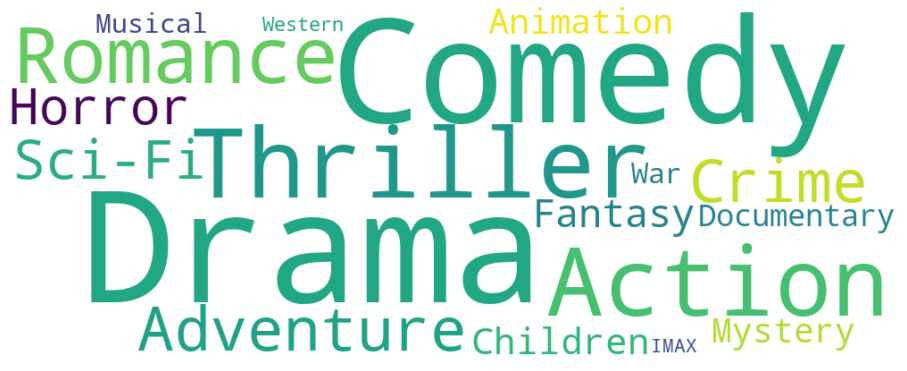

In [417]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Define the dictionary used to produce the genre wordcloud
genres = dict() # Define an empty dictionary
trunc_occurences = keyword_occurences[0:18] # Retrieve the first 18 genres from the 'keyword_occurences' variable
for s in trunc_occurences:
    genres[s[0]] = s[1]

# Create the wordcloud
genre_wordcloud = WordCloud(width=1000,height=400, background_color='white')
genre_wordcloud.generate_from_frequencies(genres)

# Plot the wordcloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(genre_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [418]:
genres

{'Action': 1828,
 'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Crime': 1199,
 'Documentary': 440,
 'Drama': 4361,
 'Fantasy': 779,
 'Horror': 978,
 'IMAX': 158,
 'Musical': 334,
 'Mystery': 573,
 'Romance': 1596,
 'Sci-Fi': 980,
 'Thriller': 1894,
 'War': 382,
 'Western': 167}

In [419]:
# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
print(movies.columns)

Number of movies Null values:  0
Number of ratings Null values:  0
Index(['movieId', 'title', 'genres'], dtype='object')


In [0]:
# Split title and release year in separate columns in movies dataframe. Convert year to timestamp.
movies1 = movies
movies1['year'] = movies1.title.str.extract("\((\d{4})\)", expand=True)
movies1.year = pd.to_datetime(movies1.year, format='%Y')
movies1.year = movies1.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies1.title = movies1.title.str[:-7]

### **Movies released per year**

In [421]:
movies.genres

0       Adventure|Animation|Children|Comedy|Fantasy
1                        Adventure|Children|Fantasy
2                                    Comedy|Romance
3                              Comedy|Drama|Romance
4                                            Comedy
                           ...                     
9737                Action|Animation|Comedy|Fantasy
9738                       Animation|Comedy|Fantasy
9739                                          Drama
9740                               Action|Animation
9741                                         Comedy
Name: genres, Length: 9742, dtype: object

(0.0, 326.5)

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Number of movies released')

Text(0.5, 1.0, 'Movies per year')

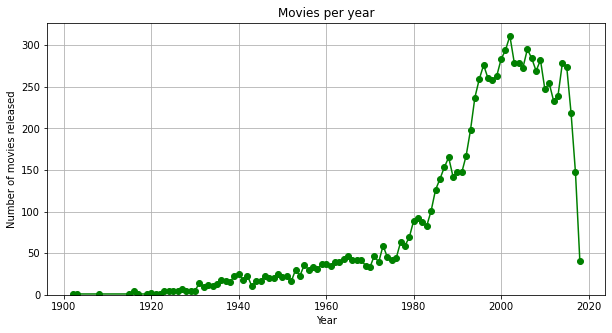

Elapsed time(sec):  0.21


In [422]:
from timeit import default_timer
start = default_timer()

st = default_timer()

# Let's work with a temp smaller slice 'dftmp' of the original dataframe to reduce runtime (ratings hass +2MM rows)
dftmp = movies[['movieId', 'year']].groupby('year')

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dftmp.year.first(), dftmp.movieId.nunique(), "g-o") # Return first true value of year.
ax1.grid(None)
ax1.set_ylim(0,)

# dftmp = df_ratings_drop_users[['rating', 'timestamp']].groupby('timestamp')
# ax2 = ax1.twinx()
# ax2.plot(dftmp.timestamp.first(), dftmp.rating.count(), "r-o")
# ax2.grid(None)
# ax2.set_ylim(0,)

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of movies released'); #ax2.set_ylabel('Number of ratings')
plt.title('Movies per year')
plt.show()

# Housekeeping
%reset_selective -f (^dftmp$|^ax1$|^ax2$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

### **Total Movies Genre**

In [0]:
# Categorize movies genres properly. Working later with +20MM rows of strings proved very resource consuming
genres_unique = pd.DataFrame(movies.genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['genre']) # Format into DataFrame to store later
movies = movies.join(movies.genres.str.get_dummies().astype(bool))
movies.drop('genres', inplace=True, axis=1)

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Year')

Text(0, 0.5, 'Cumulative number of movies-genre')

Text(0.5, 1.0, 'Total movies-genre')

<Figure size 720x360 with 0 Axes>

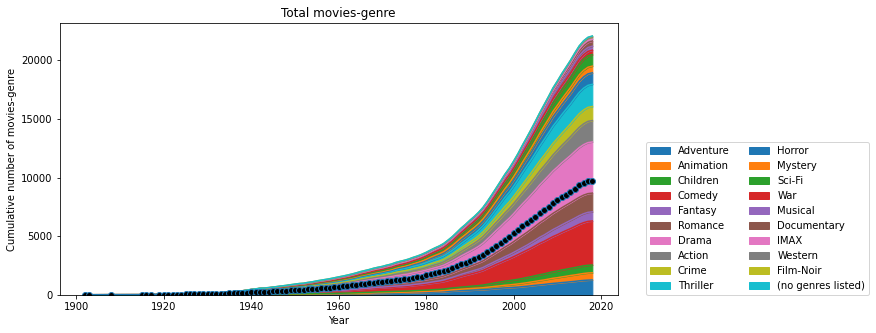

<Figure size 1080x360 with 0 Axes>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text major ticklabel objects>)

Text(0.5, 1.0, 'Movies per genre tag')

Text(0.5, 0, 'Genre')

Text(0, 0.5, 'Number of movies tagged')

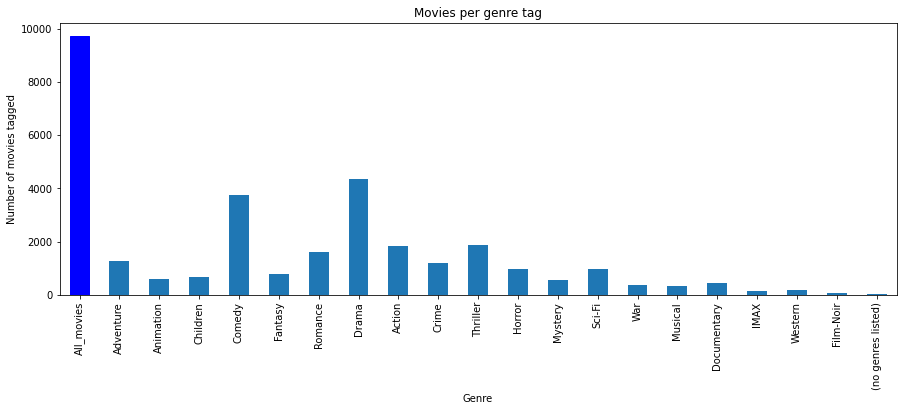

Elapsed time(sec):  0.73


In [424]:
st = default_timer()

plt.figure(figsize=(10,5))
dftmp = movies[['movieId', 'year']].groupby('year')
df = pd.DataFrame({'All_movies' : dftmp.movieId.nunique().cumsum()})
# Plot histogram for each individual genre
for genre in genres_unique.genre:
    dftmp = movies[movies[genre]][['movieId', 'year']].groupby('year')
    df[genre]=dftmp.movieId.nunique().cumsum()
df.fillna(method='ffill', inplace=True)
df.loc[:,df.columns!='All_movies'].plot.area(stacked=True, figsize=(10,5))
# Plot histogram for all movies
plt.plot(df['All_movies'], marker='o', markerfacecolor='black')
plt.xlabel('Year')
plt.ylabel('Cumulative number of movies-genre')
plt.title('Total movies-genre') # Many movies have multiple genres, so counthere is higher than number of movies
plt.legend(loc=(1.05,0), ncol=2)
plt.show()
# Plot simple scatter of the number of movies tagged with each genre
plt.figure(figsize=(15,5))
barlist = df.iloc[-1].plot.bar()
barlist.patches[0].set_color('b') # Color 'All_movies' differently, as it's not a genre tag count
plt.xticks(rotation='vertical')
plt.title('Movies per genre tag')
plt.xlabel('Genre')
plt.ylabel('Number of movies tagged')
plt.show()

# Housekeeping
%reset_selective -f (^barlist$|^dftmp$|^genre$)

runtime = default_timer() - st
print ("Elapsed time(sec): ", round(runtime,2))

**PLOT#8**: Average ratings per user.

**INSIGHT#8**: Users have a positive bias in general, with roughly 95% of their average ratings above the mid-point of 2.5. This is to be expected, and could have many explanations: users actually watch the better movies due to available ratings (and this should get better over time, as the rating system expands); users don't bother that much to rate bad movies as they do with the good ones (i.e. we don't want other to know we watched such a piece of s***), etc.

<Figure size 1080x360 with 0 Axes>

(0.0, 193609.0)

(0.0, 345.4)

Text(0.5, 1.0, 'Ratings per movie')

Text(0.5, 0, 'movieId')

Text(0, 0.5, 'Number of ratings received')

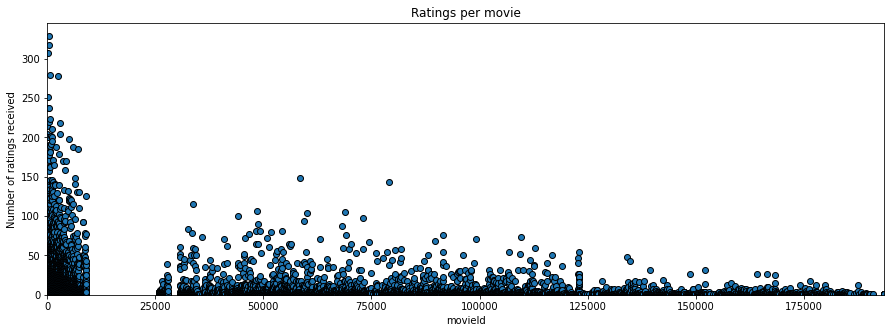

<Figure size 1080x360 with 0 Axes>

(array([6.074e+03, 9.790e+02, 5.500e+02, 4.710e+02, 2.310e+02, 1.840e+02,
        1.400e+02, 1.620e+02, 7.300e+01, 8.200e+01, 9.000e+01, 7.200e+01,
        6.700e+01, 5.800e+01, 5.500e+01, 3.300e+01, 3.000e+01, 4.500e+01,
        2.600e+01, 2.300e+01, 2.000e+01, 1.900e+01, 1.700e+01, 1.300e+01,
        1.300e+01, 1.500e+01, 1.100e+01, 1.500e+01, 1.000e+01, 8.000e+00,
        1.100e+01, 9.000e+00, 1.200e+01, 7.000e+00, 4.000e+00, 5.000e+00,
        8.000e+00, 5.000e+00, 3.000e+00, 8.000e+00, 5.000e+00, 2.000e+00,
        7.000e+00, 5.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 1.000e+00, 4.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

Text(0.5, 1.0, 'Ratings per movie')

Text(0.5, 0, 'Number of ratings received')

Text(0, 0.5, 'Number of movieIds')

(0.0, 345.40000000000003)

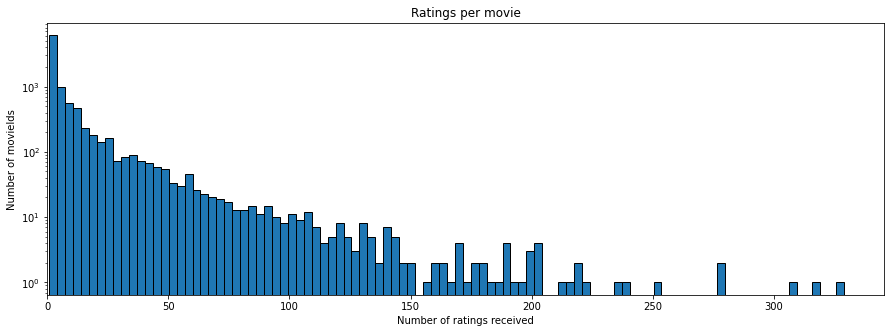

Series([], Name: title, dtype: object)


Text(0, 0.5, 'Average rating')

Text(0.5, 1.0, 'Most popular movies rating')

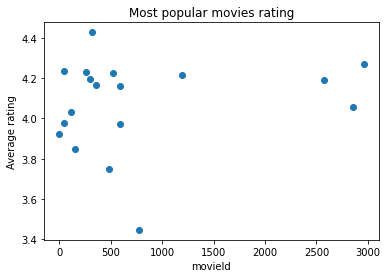

Best most popular movie ever is...Shawshank Redemption, The


In [425]:
dftmp = ratings[['userId', 'movieId']].groupby('userId').count()
dftmp.columns=['num_ratings']

st = default_timer()

# Scatter plot of all users and individual ratings count.
dftmp = ratings[['userId', 'movieId']].groupby('movieId').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,dftmp.index.max())
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per movie')
plt.xlabel('Number of ratings received')
plt.ylabel('Number of movieIds')
plt.xlim(0,)
plt.show()


# Let's check those movies with +40k reviews, those should be pretty popular movies!
print(movies.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>40000]]['title'])
# Let's check the average rating too, those should be pretty good movies!
ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>200]].groupby('movieId').mean().rating.plot(style='o')
plt.ylabel('Average rating')
plt.title('Most popular movies rating')
plt.show()

# Which is the best most popular movie ever??
tmp = ratings.set_index('movieId').loc[dftmp.index[dftmp.num_ratings>200]].groupby('movieId').mean()
best = movies.set_index('movieId').loc[tmp.rating.idxmax].title
print ('Best most popular movie ever is...%s' %best)

# **Content-Based Recommendation Model** (Input: Movie Name in dataset)

## **Implementation (Successful till the end of this section)**
With all that theory in mind, I am going to build a Content-Based Recommendation Engine that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre. To do so, I will make use of the file movies.csv.



In [426]:
cd 'data'

[Errno 2] No such file or directory: 'data'
/content


In [0]:
# Reading movies file
movies = pd.read_csv('movies.csv', sep=',', encoding='latin-1', usecols=['movieId', 'title', 'genres'])

I do not have a quantitative metric to judge our machine's performance so this will have to be done qualitatively. In order to do so, I'll use TfidfVectorizer function from scikit-learn, which transforms text to feature vectors that can be used as input to estimator.

In [428]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape

(9742, 177)

I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two movies. Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.

In [429]:
from sklearn.metrics.pairwise import linear_kernel
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:4, :4]

array([[1.        , 0.31379419, 0.0611029 , 0.05271111],
       [0.31379419, 1.        , 0.        , 0.        ],
       [0.0611029 , 0.        , 1.        , 0.35172407],
       [0.05271111, 0.        , 0.35172407, 1.        ]])


I now have a pairwise cosine similarity matrix for all the movies in the dataset. The next step is to write a function that returns the 20 most similar movies based on the cosine similarity score.

In [0]:
# Build a 1-dimensional array with movie titles
titles = movies['title']
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]


Let's try and get the top recommendations for a few movies and see how good the recommendations are.

In [431]:
genre_recommendations('Good Will Hunting (1997)').head(20)

24                            Leaving Las Vegas (1995)
27                                   Persuasion (1995)
42                How to Make an American Quilt (1995)
45                        When Night Is Falling (1995)
66                                 Bed of Roses (1996)
75     Once Upon a Time... When We Were Colored (1995)
76                           Angels and Insects (1995)
93               Bridges of Madison County, The (1995)
115                       Up Close and Personal (1996)
151                                    Mad Love (1995)
162                         Scarlet Letter, The (1995)
170                               Total Eclipse (1995)
175                       Walk in the Clouds, A (1995)
183                              Before Sunrise (1995)
189                           Circle of Friends (1995)
213                            Immortal Beloved (1994)
232                                 Love Affair (1994)
261                  Picture Bride (Bijo photo) (1994)
262       

In [432]:
genre_recommendations('Toy Story (1995)').head(20)

1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (AstÃ©rix et les Vikin...
8219                                         Turbo (2013)
8927                             The Good Dinosaur (2015)
9430                                         Moana (2016)
5490    Twelve Tasks of Asterix, The (Les douze travau...
6448           TMNT (Teenage Mutant Ninja Turtles) (2007)
8357                                The Lego Movie (2014)
3194                                         Shrek (2001)
7530                               Gnomeo & Juliet (2011)
7805        Pu

As you can see, I have quite a decent list of recommendation for **Good Will Hunting (Drama)**, **Toy Story (Animation, Children's**, Comedy), and **Saving Private Ryan (Action, Thriller, War)**.

Overall, here are the pros of using content-based recommendation:

* No need for data on other users, thus no cold-start or sparsity problems.
* Can recommend to users with unique tastes.
* Can recommend new & unpopular items.
* Can provide explanations for recommended items by listing content-features that caused an item to be recommended (in this case, movie genres)

However, there are some cons of using this approach:

* Finding the appropriate features is hard.
* Does not recommend items outside a user's content profile.
* Unable to exploit quality judgments of other users.

# **Collaborative Filtering Recommendation Model**
The content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, I will use Memory-Based Collaborative Filtering to make recommendations to movie users. The technique is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.

## **Theory**

There are 2 main types of memory-based collaborative filtering algorithms:

1. **User-User Collaborative Filtering**: Here we find look alike users based on similarity and recommend movies which first user’s look-alike has chosen in past. This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time. Therefore, for big base platforms, this algorithm is hard to implement without a very strong parallelizable system.

2. **Item-Item Collaborative Filtering**: It is quite similar to previous algorithm, but instead of finding user's look-alike, we try finding movie's look-alike. Once we have movie's look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset. This algorithm is far less resource consuming than user-user collaborative filtering. Hence, for a new user, the algorithm takes far lesser time than user-user collaborate as we don’t need all similarity scores between users. And with fixed number of movies, movie-movie look alike matrix is fixed over time.

In either scenario, we builds a similarity matrix. For user-user collaborative filtering, the user-similarity matrix will consist of some distance metrics that measure the similarity between any two pairs of users. Likewise, the item-similarity matrix will measure the similarity between any two pairs of items.

There are 3 distance similarity metrics that are usually used in collaborative filtering:

1. **Jaccard Similarity:**

* Similarity is based on the number of users which have rated item A and B divided by the number of users who have rated either A or B
* It is typically used where we don’t have a numeric rating but just a boolean value like a product being bought or an add being clicked

2. Cosine Similarity: (as in the Content-Based system)

* Similarity is the cosine of the angle between the 2 vectors of the item vectors of A and B
* Closer the vectors, smaller will be the angle and larger the cosine

3. Pearson Similarity:

* Similarity is the pearson coefficient between the two vectors.

For the purpose of diversity, I will use Pearson Similarity in this implementation.

## **Implementation**

I will use the file ratings.csv first as it contains User ID, Movie IDs and Ratings. These three elements are all I need for determining the similarity of the users based on their ratings for a particular movie.

First I will be doing some quick Data Pre-Processing:


Due to the limited computing power in my laptop, I will build the recommender system using only a subset of the ratings. In particular, I will take a random sample of 20,000 ratings (20%) from the 1M ratings.

Now I use the scikit-learn library to split the dataset into testing and training. Cross_validation.train_test_split shuffles and splits the data into two datasets according to the percentage of test examples, which in this case is 0.2.


Now I need to create a user-item matrix. Since I have splitted the data into testing and training, I need to create two matrices. The training matrix contains 80% of the ratings and the testing matrix contains 20% of the ratings.


Now I use the pairwise_distances function from sklearn to calculate the Pearson Correlation Coefficient. This method provides a safe way to take a distance matrix as input, while preserving compatibility with many other algorithms that take a vector array.

With the similarity matrix in hand, I can now predict the ratings that were not included with the data. Using these predictions, I can then compare them with the test data to attempt to validate the quality of our recommender model.

For the user-user CF case, I will look at the similarity between 2 users (A and B, for example) as weights that are multiplied by the ratings of a similar user B (corrected for the average rating of that user). I also need to normalize it so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that I am trying to predict. The idea here is that some users may tend always to give high or low ratings to all movies. The relative difference in the ratings that these users give is more important than the absolute values.

In [0]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

Evaluation
There are many evaluation metrics but one of the most popular metric used to evaluate accuracy of predicted ratings is Root Mean Squared Error (RMSE). I will use the mean_square_error (MSE) function from sklearn, where the RMSE is just the square root of MSE.

$$\mathit{RMSE} =\sqrt{\frac{1}{N} \sum (x_i -\hat{x_i})^2}$$
I'll use the scikit-learn's mean squared error function as my validation metric. Comparing user- and item-based collaborative filtering, it looks like user-based collaborative filtering gives a better result.

# **3. Train KNN model for item-based collaborative filtering** (Input movie in dataset, output movies with distance)

>Reshaping the Data

>Fitting the Model

### **1. Reshaping the Data**

For** K-Nearest Neighbors**, we want the data to be in a (movie, user) array, where each row is a movie and each column is a different user. To reshape the dataframe, **we'll pivot the dataframe** to the wide format with ***movies as rows*** and ***users as columns***. Then we'll fill the missing observations with 0s since we're going to be performing linear algebra operations (calculating distances between vectors). Finally, we transform the values of the dataframe into a **scipy sparse matrix** for **more efficient calculations**.

In [0]:
from scipy.sparse import csr_matrix
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

In [435]:
print(movie_user_mat.head())
print(movie_user_mat_sparse)

userId   1    4    6    7    15   16   17   ...  603  604  605  606  607  608  610
movieId                                     ...                                   
1        4.0  0.0  0.0  4.5  2.5  0.0  4.5  ...  4.0  3.0  4.0  2.5  4.0  2.5  5.0
2        0.0  0.0  4.0  0.0  0.0  0.0  0.0  ...  0.0  5.0  3.5  0.0  0.0  2.0  0.0
3        4.0  0.0  5.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0  2.0  0.0
6        4.0  0.0  4.0  0.0  0.0  0.0  0.0  ...  4.0  3.0  0.0  0.0  0.0  0.0  5.0
7        0.0  0.0  4.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  2.5  0.0  0.0  0.0

[5 rows x 268 columns]
  (0, 0)	4.0
  (0, 3)	4.5
  (0, 4)	2.5
  (0, 6)	4.5
  (0, 7)	3.5
  (0, 8)	4.0
  (0, 10)	3.5
  (0, 13)	3.0
  (0, 15)	3.0
  (0, 16)	3.0
  (0, 20)	5.0
  (0, 23)	5.0
  (0, 24)	4.0
  (0, 26)	3.0
  (0, 29)	5.0
  (0, 32)	5.0
  (0, 33)	4.0
  (0, 34)	4.0
  (0, 35)	2.5
  (0, 36)	4.5
  (0, 37)	0.5
  (0, 39)	2.5
  (0, 42)	3.0
  (0, 43)	4.0
  (0, 44)	3.0
  :	:
  (449, 94)	3.5
  (449, 108)	3.0
  (449, 114)

## **2. Fitting the Model**

Time to implement the model. We'll initialize the NearestNeighbors class as model_knn and fit our sparse matrix to the instance. By specifying the metric = cosine, the model will measure similarity bectween artist vectors by using cosine similarity.

In [436]:
from sklearn.neighbors import NearestNeighbors
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

## **4. Use this trained model to make movie recommendations**

And we're finally ready to make some recommendations!

### Creating Functions for Movie Recommendation System for prediction

In [437]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
# Function for searching through the dataframe(database) for the specified movie
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]


# Function for providing movies recommednation based on user input and distance through K Nearest Neighbors 
def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [438]:
movieTitle = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=movieTitle,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)']

Recommendation system start to make inference
......

Recommendations for Iron Man:
1: Batman Begins (2005), with distance of 0.34744154173084363
2: Sherlock Holmes (2009), with distance of 0.3463540530285869
3: Kung Fu Panda (2008), with distance of 0.34323498779508776
4: Inception (2010), with distance of 0.33073992134058794
5: District 9 (2009), with distance of 0.3187720802539473
6: Up (2009), with distance of 0.31706735090314886
7: WALLÂ·E (2008), with distance of 0.27033112296383466
8: Avengers, The (2012), with distance of 0.2610290662950412
9: Avatar (2009), with distance of 0.2599024893009969
10: Dark Knight, The (2008), with distance of 0.24019004841992464


This is very interesting that my KNN model recommends movies that were also produced in very similar years. However, the cosine distance of all those recommendations are actually quite small. This is probabily because there is too many zero values in our movie-user matrix. With too many zero values in our data, the data sparsity becomes a real issue for KNN model and the distance in KNN model starts to fall apart. So I'd like to dig deeper and look closer inside our data.

**Larger cosine value means better predictions and the points are closer to each other. However, it is used when the magnitude of the vector does not matter.**

**(extra inspection)**

Let's now look at how sparse the movie-user matrix is by calculating percentage of zero values in the data.

In [439]:
# calcuate total number of entries in the movie-user matrix
num_entries = movie_user_mat.shape[0] * movie_user_mat.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_user_mat==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 72.64% of ratings in our data is missing


This result confirms my hypothesis. The vast majority of entries in our data is zero. This explains why the distance between similar items or opposite items are both pretty large.

# **Recommender Systems Collaborative Filtering (Cosine Similarity Predictions,KNN Algorithm)**
Testing set created using movies not yet reviewed by users which increases the variability of the testing set and allows for a much objective prediction as the training and testing set would be very different.

For this section, I will be using the cosine similarity between movies to make new recommendations. Although I explained collaborative filtering based on user similarity, we can just as easily use item-item similarity to make recommendations. With item-item collaborative filtering, each movie has a vector of all its ratings, and we compute the cosine similarity between two movies’ rating vectors.

In [0]:
data = Dataset.load_builtin("ml-100k")
trainingSet = data.build_full_trainset()
from surprise import KNNBasic
sim_options = {
    'name': 'cosine',
    'user_based': False
}
 
knn = KNNBasic(sim_options=sim_options)
knn.fit(trainingSet)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] 

Now that we have trained our model, we want to make movie recommendations for users. Using the build_anti_testset method, we can find all user-movie pairs in the training set where the user has not viewed the movie and create a “testset” out of these entries.

In [0]:
testSet = trainingSet.build_anti_testset()
predictions = knn.test(testSet)

In [0]:
from collections import defaultdict
 
def get_top3_recommendations(predictions, topN = 3):
     
    top_recs = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_recs[uid].append((iid, est))
     
    for uid, user_ratings in top_recs.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_recs[uid] = user_ratings[:topN]
     
    return top_recs

In our dataset, each user and movie is represented with an ID number. If we were to view the output of our model now, we would receive a list of movie IDs for each user; not a result we can easily interpret. Therefore, we will use a second helper method read_item_names to create a dictionary that maps each movie’s ID to its name. This method is based on one of the examples in the Suprise library’s Github repo.

In [0]:
import os, io
 
def read_item_names():
    """Read the u.item file from MovieLens 100-k dataset and returns a
    mapping to convert raw ids into movie names.
    """
 
    file_name = (os.path.expanduser('~') +
                 '/.surprise_data/ml-100k/ml-100k/u.item')
    rid_to_name = {}
    with io.open(file_name, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            line = line.split('|')
            rid_to_name[line[0]] = line[1]
 
    return rid_to_name

Now, we can call our get_top3_recommendations method to get the top movie recommendations for each user and output the result.

In [0]:
top3_recommendations = get_top3_recommendations(predictions)
rid_to_name = read_item_names()
for uid, user_ratings in top3_recommendations.items():
    print(uid, [rid_to_name[iid] for (iid, _) in user_ratings])

As you can see, each user receives personalized movie recommendations based on how they rated the movies they have seen.

One of the major weaknesses of collaborative filtering is the cold-start problem: How do we make recommendations to new users whom we have little to no data about their preferences? Since we have no information about the user’s preferences, we cannot accurately compute the similarity between the new user and more established users.